In [1]:
%pip install flwr flwr-datasets
%pip install -U "flwr[simulation]"
%pip install cvxpy 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.1/532.1 kB 8.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.12.0
    Uninstalling fsspec-2024.12.0:
      Successfully uninstalled fsspec-2024.12.0
  Attempting uninstall: typer
    Found existing installation: typer 0.15.1
    Uninstalling typer-0.15.

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg ,FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context
from flwr_datasets.partitioner import PathologicalPartitioner

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cuda
Flower 1.16.0 / PyTorch 2.5.1+cu121


In [3]:
# Parameters
NUM_PARTITIONS = 20  # Number of clients
BATCH_SIZE = 32
FL_ROUNDS = 100
LOCAL_EPOCHS = 10
NUM_SELECTED_CLIENTS = 10
CLASSES_PER_CLIENT = 2
save_dir='./client_data'
batch_size: int = 32

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import os
import torch
import numpy as np
import itertools
import cvxpy as cp
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from math import comb  # Add this import

def load_non_iid_datasets(num_partitions: int):
    # Load CIFAR-10 dataset
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)

    # Extract data and labels
    data, labels = next(iter(trainloader))

    # Define parameters
    classesPerDevice = 3
    nDevices = num_partitions  # Number of devices (clients)
    nCopies = int(np.ceil(nDevices / comb(10, classesPerDevice)))  # Number of copies

    # Count instances per class
    nRecordsClass = np.bincount(labels.numpy(), minlength=10)

    # Generate all combinations of classes for devices
    classCombinations = list(itertools.combinations(range(10), classesPerDevice))

    # Initialize probabilities matrix
    d = nDevices
    l = 10
    p = cp.Variable((d, l))

    # Define constraints
    constraints = []

    # Constraint: Probabilities for each device sum to 1
    for i in range(d):
        constraints.append(cp.sum(p[i, :]) == 1)

    # Constraint: Probabilities for each class are proportional to the number of instances
    for j in range(l):
        constraints.append(cp.sum(p[:, j]) == d * nRecordsClass[j] / sum(nRecordsClass))

    # Constraint: Probabilities are non-negative
    constraints.append(p >= 0)

    # Assign classes to devices based on combinations
    deviceClassAssignments = []
    for i in range(d):
        if i < len(classCombinations):
            deviceClassAssignments.append(classCombinations[i])
        else:
            # Repeat combinations if necessary
            deviceClassAssignments.append(classCombinations[i % len(classCombinations)])

    # Set probabilities to zero for unassigned classes
    for i in range(d):
        for j in range(l):
            if j not in deviceClassAssignments[i]:
                constraints.append(p[i, j] == 0)

    # Objective function to distribute probabilities evenly among selected classes
    alpha = np.random.uniform(0, 1, size=(d, l))
    objective = cp.Minimize(cp.sum_squares(p - alpha))

    # Solve optimization problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Assign instances to devices based on probabilities
    deviceData = [[] for _ in range(d)]
    for i, label in enumerate(labels):
        # Select a device based on the class of the instance
        classIndex = label.item()
        deviceProbabilities = np.zeros(d)
        
        for j, classes in enumerate(deviceClassAssignments):
            if classIndex in classes:
                deviceProbabilities[j] = p.value[j, classIndex]
        
        # Ensure probabilities are non-negative and sum to a non-zero value
        deviceProbabilities = np.clip(deviceProbabilities, a_min=0, a_max=None)
        sumProbabilities = np.sum(deviceProbabilities)
        
        if sumProbabilities == 0:
            # If sum is zero, assign to a random device
            deviceIndex = np.random.choice(d)
        else:
            # Normalize probabilities
            deviceProbabilities /= sumProbabilities
            # Select a device based on these probabilities
            deviceIndex = np.random.choice(d, p=deviceProbabilities)
        
        # Append the instance to the selected device
        deviceData[deviceIndex].append((data[i], label))
        
    # Verify non-i.i.d. property
    for i, data in enumerate(deviceData):
        if data:
            classes, counts = np.unique([y for _, y in data], return_counts=True)
            print(f"Device {i+1} classes and counts: {dict(zip(classes, counts))}")
        else:
            print(f"Device {i+1} is empty.")

    # Save each client's data to disk
    os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

    for i, client_data in enumerate(deviceData):
        if client_data:
            client_file_path = os.path.join(save_dir, f"client_{i}.pt")
            torch.save(client_data, client_file_path)
            print(f"Client {i+1} data saved to {client_file_path}")
        else:
            print(f"Client {i+1} has no data.")

In [5]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np



def load_data_from_disk(partition_id: int, only_server_test_data: bool = False):
    if not only_server_test_data:
        # Load the saved data for the partition
        partition_data_path = os.path.join(save_dir, f'client_{partition_id}.pt')
        print(f"Loading client: {partition_id}")
    
        # Load the data
        device_data = torch.load(partition_data_path, weights_only=True)
        
        # Divide data into 80% train and 20% test
        np.random.shuffle(device_data)
        train_size = int(len(device_data) * 0.8)
        train_data = device_data[:train_size]
        test_data = device_data[train_size:]
    
        # Define PyTorch transforms for normalization only
        pytorch_transforms = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization only, no ToTensor
        ])
    
        # Apply transforms to data
        train_data = [(pytorch_transforms(x), y) for x, y in train_data]
        test_data = [(pytorch_transforms(x), y) for x, y in test_data]
    
        # Create data loaders
        trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
        valloader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=1)
        
        return trainloader, valloader
    else:
        # Load the test set for CIFAR-10 from the original dataset (if needed separately for validation)
        testset = torchvision.datasets.CIFAR10(
            root='./data',
            train=False,
            download=True,
            transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        )
        testloader = DataLoader(testset, batch_size=batch_size, num_workers=8)

        return testloader

In [6]:
load_non_iid_datasets(NUM_PARTITIONS)

100%|██████████| 170M/170M [00:01<00:00, 98.0MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Device 1 classes and counts: {0: 702, 1: 1429, 2: 422}
Device 2 classes and counts: {0: 1221, 1: 121, 3: 1212}
Device 3 classes and counts: {1: 548, 4: 1932}
Device 4 classes and counts: {1: 476, 5: 2011}
Device 5 classes and counts: {1: 1071, 6: 1411}
Device 6 classes and counts: {0: 129, 1: 1355, 7: 976}
Device 7 classes and counts: {0: 687, 8: 1820}
Device 8 classes and counts: {9: 2517}
Device 9 classes and counts: {0: 173, 2: 1510, 3: 792}
Device 10 classes and counts: {2: 985, 4: 1527}
Device 11 classes and counts: {0: 3, 2: 1311, 5: 1215}
Device 12 classes and counts: {2: 546, 6: 1935}
Device 13 classes and counts: {2: 226, 7: 2253}
Device 14 classes and counts: {8: 2449}
Device 15 classes and counts: {9: 2483}
Device 16 classes and counts: {3: 945, 4: 1541}
Device 17 classes and counts: {3: 754, 5: 1774}
Device 18 classes and counts: {0: 479, 3: 377, 6: 1654}
Device 19 classes and counts: {0: 161, 3: 596, 7: 1771}
Device 20 cla

In [7]:
# Load data for all clients and calculate label distributions
from collections import Counter

label_distributions = []
for client_id in range(NUM_PARTITIONS):
    trainloader, _ = load_data_from_disk(client_id, False)
    labels = []
    for batch in trainloader:
        if len(batch) != 2:
            raise ValueError(f"Unexpected batch structure: {batch}")
        labels.extend(batch[1].tolist())
    label_distributions.append(Counter(labels))


Loading client: 0
Loading client: 1
Loading client: 2
Loading client: 3
Loading client: 4
Loading client: 5
Loading client: 6
Loading client: 7
Loading client: 8
Loading client: 9
Loading client: 10
Loading client: 11
Loading client: 12
Loading client: 13
Loading client: 14
Loading client: 15
Loading client: 16
Loading client: 17
Loading client: 18
Loading client: 19


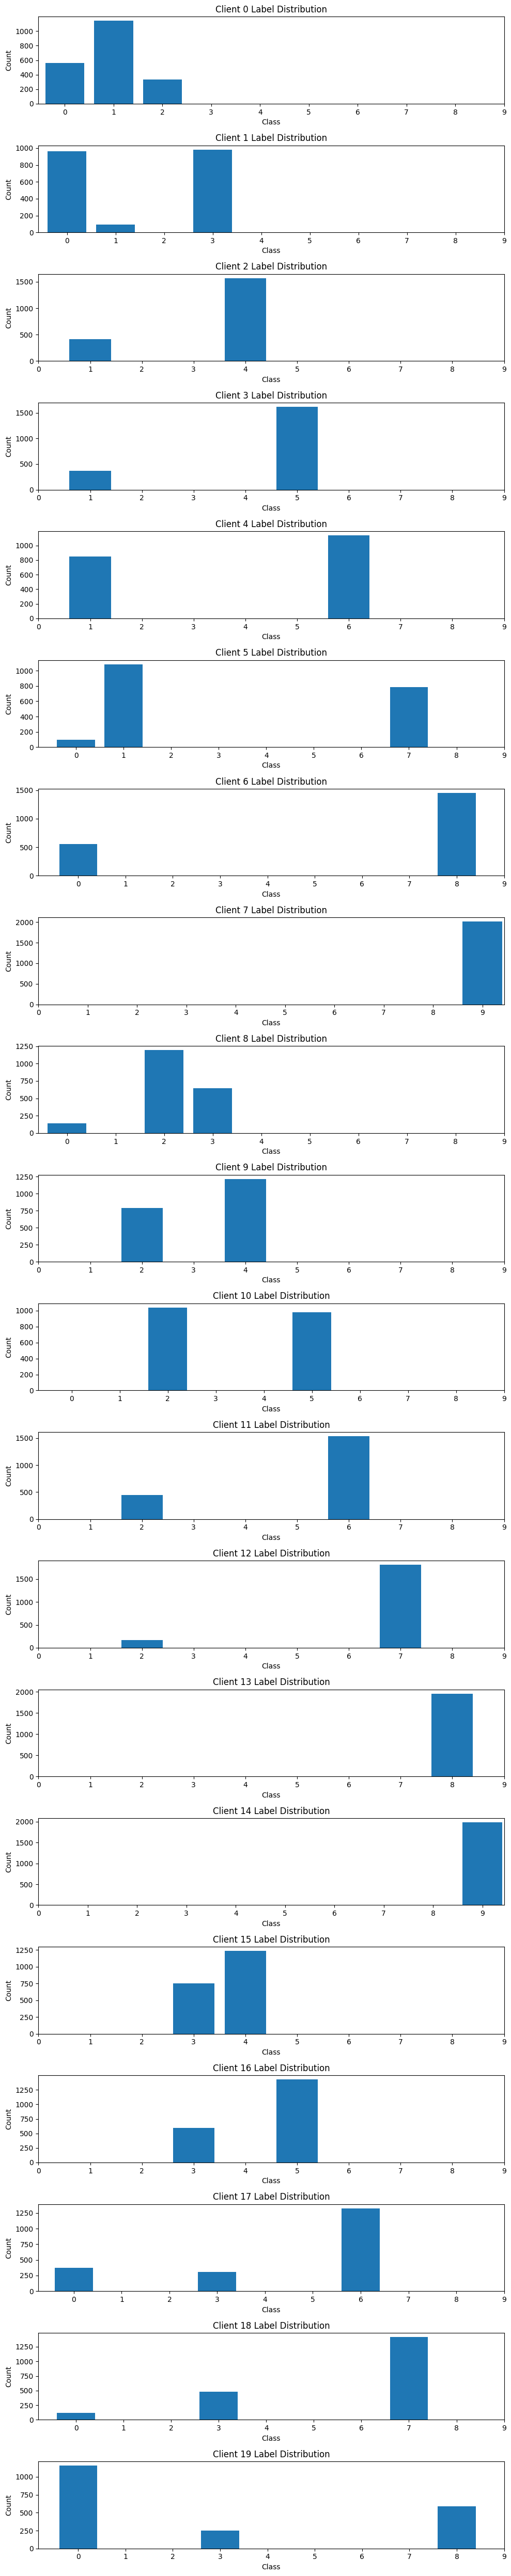

In [8]:

# Plot label distributions for each client
fig, axs = plt.subplots(NUM_PARTITIONS, 1, figsize=(10, 50))
for i, (ax, distribution) in enumerate(zip(axs, label_distributions)):
    ax.bar(distribution.keys(), distribution.values())
    ax.set_xticks(range(10))  # Set ticks for 0 to 9
    ax.set_xticklabels(range(10))  # Set labels for 0 to 9
    ax.set_title(f"Client {i} Label Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [9]:
# def load_datasets(partition_id: int, num_partitions: int):
#     return load_non_iid_datasets(partition_id, num_partitions)

In [10]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Step 3: Define the neural network using PyTorch


In [11]:
def initialize_model():
    model = Net()
    
    # Handle DataParallel first before moving to device
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
        
    model = model.to(DEVICE)
    return model

In [12]:


# Function to train the model
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""

    criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch[0], batch[1]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

# Function to evaluate the model
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch[0], batch[1]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Function to get model parameters
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

# Function to set model parameters
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [13]:
# Define the FlowerClient class
class FlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs= LOCAL_EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)

    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader = load_data_from_disk(partition_id, False)
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [14]:
# Lists to store the results
loss_history = []
accuracy_history = []

# The `evaluate` function will be called by Flower after every round of training in Server
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = Net().to(DEVICE)
    testloader = load_data_from_disk(0, True)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    # Store the results
    loss_history.append(loss)
    accuracy_history.append(accuracy)
    return loss, {"accuracy": accuracy}

# Create an instance of the model and get the parameters
params = get_parameters(Net())

def server_fn(context: Context) -> ServerAppComponents:
    # Create the FedAvg strategy
    strategy = FedProx(
        fraction_fit=NUM_SELECTED_CLIENTS/NUM_PARTITIONS,
        fraction_evaluate=0.5,
        min_fit_clients=NUM_SELECTED_CLIENTS,
        min_evaluate_clients=10,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
        proximal_mu=0.01
    )
    # Configure the server for 150 rounds of training
    config = ServerConfig(num_rounds=FL_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

In [15]:
# Create ServerApp
server = ServerApp(server_fn=server_fn)

In [16]:
# Specify the resources each of your clients need
# Allocate all 8 CPU cores to each client
num_cpus = min(4, torch.get_num_threads())  # Limit to 4 but adapt to system
num_gpus = torch.cuda.device_count()  # Get available GPUs

# Set backend configuration dynamically
backend_config = {"client_resources": {"num_cpus": num_cpus}}
if num_gpus > 0:
    backend_config["client_resources"]["num_gpus"] = num_gpus

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,  # Number of clients
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=100, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO :      initial parameters (loss, other metrics): 0.07212380583286285, {'accuracy': 0.0997}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.07212380583286285 / accuracy 0.0997


(pid=581) 2025-03-17 07:39:09.208732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=581) 2025-03-17 07:39:09.231840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=581) 2025-03-17 07:39:09.239148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.033750105649232864, accuracy 0.5881488736532811
(ClientAppActor pid=581) Epoch 2: train loss 0.024631012231111526, accuracy 0.6596474045053868
(ClientAppActor pid=581) Epoch 3: train loss 0.0229746475815773, accuracy 0.6998041136141038
(ClientAppActor pid=581) Epoch 4: train loss 0.01978444494307041, accuracy 0.7492654260528894
(ClientAppActor pid=581) Epoch 5: train loss 0.017487119883298874, accuracy 0.7855044074436827
(ClientAppActor pid=581) Epoch 6: train loss 0.015655169263482094, accuracy 0.8031341821743389
(ClientAppActor pid=581) Epoch 7: train loss 0.015378390438854694, accuracy 0.8001958863858962
(ClientAppActor pid=581) Epoch 8: train loss 0.013627891428768635, accuracy 0.8251714005876591
(ClientAppActor pid=581) Epoch 9: train loss 0.01264145690947771, accuracy 0.8374142997061704
(ClientAppActor pid=581) Epoch 10: 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.005554464645683765, accuracy 0.9324937027707808
Files already downloaded and verified


INFO :      fit progress: (1, 0.08033262448310852, {'accuracy': 0.1}, 64.77770572300005)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08033262448310852 / accuracy 0.1
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Lo

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.026241401210427284, accuracy 0.653281096963761
(ClientAppActor pid=581) Epoch 2: train loss 0.019194722175598145, accuracy 0.7546523016650343
(ClientAppActor pid=581) Epoch 3: train loss 0.01726602204144001, accuracy 0.7840352595494613
(ClientAppActor pid=581) Epoch 4: train loss 0.01442028395831585, accuracy 0.8134182174338883
(ClientAppActor pid=581) Epoch 5: train loss 0.01298186182975769, accuracy 0.8403525954946132
(ClientAppActor pid=581) Epoch 6: train loss 0.012332488782703876, accuracy 0.8501469147894222
(ClientAppActor pid=581) Epoch 7: train loss 0.011749587021768093, accuracy 0.8555337904015671
(ClientAppActor pid=581) Epoch 8: train loss 0.010867077857255936, accuracy 0.8658178256611165
(ClientAppActor pid=581) Epoch 9: train loss 0.010534247383475304, accura

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.011043921113014221, accuracy 0.8456973293768546
Files already downloaded and verified


INFO :      fit progress: (2, 0.07796494023799896, {'accuracy': 0.1858}, 131.47027726200008)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.07796494023799896 / accuracy 0.1858
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.013097932562232018, accuracy 0.8639112903225806
(ClientAppActor pid=581) Epoch 2: train loss 0.005214311182498932, accuracy 0.9400201612903226
(ClientAppActor pid=581) Epoch 3: train loss 0.004243864212185144, accuracy 0.9516129032258065
(ClientAppActor pid=581) Epoch 4: train loss 0.003638015128672123, accuracy 0.9551411290322581
(ClientAppActor pid=581) Epoch 5: train loss 0.003002388868480921, accuracy 0.9647177419354839
(ClientAppActor pid=581) Epoch 6: train loss 0.00308305979706347, accuracy 0.9632056451612904
(ClientAppActor pid=581) Epoch 7: train loss 0.00258811772800982, accuracy 0.9717741935483871
(ClientAppActor pid=581) Epoch 8: train loss 0.003180402098223567, accuracy 0.9591733870967742
(ClientAppActor pid=581) Epoch 9: train loss 0.002108873799443245, acc

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.01064494252204895, accuracy 0.8546277665995976
Files already downloaded and verified


INFO :      fit progress: (3, 0.07432915461063384, {'accuracy': 0.1923}, 197.556592475)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.07432915461063384 / accuracy 0.1923
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.007136644329875708, accuracy 0.9238911290322581
(ClientAppActor pid=581) Epoch 2: train loss 0.0041909790597856045, accuracy 0.9490927419354839
(ClientAppActor pid=581) Epoch 3: train loss 0.003763869870454073, accuracy 0.9576612903225806
(ClientAppActor pid=581) Epoch 4: train loss 0.002956851152703166, accuracy 0.9642137096774194
(ClientAppActor pid=581) Epoch 5: train loss 0.0026000309735536575, accuracy 0.96875
(ClientAppActor pid=581) Epoch 6: train loss 0.0019924736116081476, accuracy 0.9758064516129032
(ClientAppActor pid=581) Epoch 7: train loss 0.0019039680482819676, accuracy 0.9747983870967742
(ClientAppActor pid=581) Epoch 8: train loss 0.0013657292583957314, accuracy 0.9838709677419355
(ClientAppActor pid=581) Epoch 9: train loss 0.0017549694748595357, accuracy 0.9803427419354839
(ClientAppActor pid=581) Epoch 10: t

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0008525096927769482, accuracy 0.9909502262443439
Files already downloaded and verified


INFO :      fit progress: (4, 0.07472498766183854, {'accuracy': 0.2279}, 263.208706227)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.07472498766183854 / accuracy 0.2279
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.016837000846862793, accuracy 0.7943192948090108
(ClientAppActor pid=581) Epoch 2: train loss 0.01263658981770277, accuracy 0.8403525954946132
(ClientAppActor pid=581) Epoch 3: train loss 0.011589585803449154, accuracy 0.8511263467189031
(ClientAppActor pid=581) Epoch 4: train loss 0.009930577129125595, accuracy 0.8746327130264446
(ClientAppActor pid=581) Epoch 5: train loss 0.009093217551708221, accuracy 0.8819784524975515
(ClientAppActor pid=581) Epoch 6: train loss 0.008509308099746704, accuracy 0.8927522037218414
(ClientAppActor pid=581) Epoch 7: train loss 0.007066399324685335, accuracy 0.915279138099902
(ClientAppActor pid=581) Epoch 8: train loss 0.006112069822847843, accuracy 0.9245837414299706
(ClientAppActor pid=581) Epoch 9: train loss 0.0050207204185426235, acc

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.000369255110854283, accuracy 0.9969758064516129
Files already downloaded and verified


INFO :      fit progress: (5, 0.08740291081666947, {'accuracy': 0.2733}, 329.12624028900007)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08740291081666947 / accuracy 0.2733
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.011628260836005211, accuracy 0.860009789525208
(ClientAppActor pid=581) Epoch 2: train loss 0.008418641053140163, accuracy 0.9025942241801272
(ClientAppActor pid=581) Epoch 3: train loss 0.0075045195408165455, accuracy 0.9069995105237396
(ClientAppActor pid=581) Epoch 4: train loss 0.007075974717736244, accuracy 0.9109153206069506
(ClientAppActor pid=581) Epoch 5: train loss 0.006219578441232443, accuracy 0.924620655898189
(ClientAppActor pid=581) Epoch 6: train loss 0.004644677974283695, accuracy 0.9486049926578561
(ClientAppActor pid=581) Epoch 7: train loss 0.004551288206130266, accuracy 0.9515418502202643
(ClientAppActor pid=581) Epoch 8: train loss 0.00313173932954669, accuracy 0.9657366617719041
(ClientAppActor pid=581) Epoch 9: train loss 0.0028614795301109552, acc

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 2.1687968398964586e-07, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (6, 0.08675291386842728, {'accuracy': 0.2733}, 394.56222879100005)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08675291386842728 / accuracy 0.2733
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.012778554111719131, accuracy 0.8810975609756098
(ClientAppActor pid=581) Epoch 2: train loss 0.005755748134106398, accuracy 0.9441056910569106
(ClientAppActor pid=581) Epoch 3: train loss 0.0049957274459302425, accuracy 0.9451219512195121
(ClientAppActor pid=581) Epoch 4: train loss 0.003898083698004484, accuracy 0.9547764227642277
(ClientAppActor pid=581) Epoch 5: train loss 0.003537804586812854, accuracy 0.961890243902439
(ClientAppActor pid=581) Epoch 6: train loss 0.0022959860507398844, accuracy 0.978150406504065
(ClientAppActor pid=581) Epoch 7: train loss 0.002113318769261241, accuracy 0.978150406504065
(ClientAppActor pid=581) Epoch 8: train loss 0.0015457873232662678, accuracy 0.9847560975609756
(ClientAppActor pid=581) Epoch 9: train loss 0.0007879275362938643, a

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0029549584724009037, accuracy 0.9668008048289738
Files already downloaded and verified


INFO :      fit progress: (7, 0.08150429532527924, {'accuracy': 0.3065}, 460.296286872)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08150429532527924 / accuracy 0.3065
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.006677898578345776, accuracy 0.9270990447461036
(ClientAppActor pid=581) Epoch 2: train loss 0.0017802774673327804, accuracy 0.9819004524886877
(ClientAppActor pid=581) Epoch 3: train loss 0.0015444604214280844, accuracy 0.9829059829059829
(ClientAppActor pid=581) Epoch 4: train loss 0.0011576549150049686, accuracy 0.9854198089492208
(ClientAppActor pid=581) Epoch 5: train loss 0.0009983280906453729, accuracy 0.9889391654097537
(ClientAppActor pid=581) Epoch 6: train loss 0.0005752476863563061, accuracy 0.9939668174962293
(ClientAppActor pid=581) Epoch 7: train loss 0.0005482777487486601, accuracy 0.9949723479135244
(ClientAppActor pid=581) Epoch 8: train loss 0.00010433869465487078, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 4.572974285110831e-05, accuracy

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0007652565254829824, accuracy 0.9924357034795764
Files already downloaded and verified


INFO :      fit progress: (8, 0.08460140889883042, {'accuracy': 0.2843}, 525.4661303690001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08460140889883042 / accuracy 0.2843
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.012909647077322006, accuracy 0.8530852105778648
(ClientAppActor pid=581) Epoch 2: train loss 0.008602728135883808, accuracy 0.895690499510284
(ClientAppActor pid=581) Epoch 3: train loss 0.0065566543489694595, accuracy 0.9226248775710089
(ClientAppActor pid=581) Epoch 4: train loss 0.005012392997741699, accuracy 0.9397649363369246
(ClientAppActor pid=581) Epoch 5: train loss 0.0032883111853152514, accuracy 0.9647404505386875
(ClientAppActor pid=581) Epoch 6: train loss 0.0023715810384601355, accuracy 0.9760039177277179
(ClientAppActor pid=581) Epoch 7: train loss 0.0015206029638648033, accuracy 0.9877571008814887
(ClientAppActor pid=581) Epoch 8: train loss 0.00093266082694754, accuracy 0.9936336924583742
(ClientAppActor pid=581) Epoch 9: train loss 0.0005804219399578869, accuracy 0.9975514201762977
(ClientAppActor pid=581) Epo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0009449254139326513, accuracy 0.9903455284552846
Files already downloaded and verified


INFO :      fit progress: (9, 0.08980497903823853, {'accuracy': 0.3123}, 590.7248356440001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08980497903823853 / accuracy 0.3123
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.005038444418460131, accuracy 0.9455645161290323
(ClientAppActor pid=581) Epoch 2: train loss 0.0016550159780308604, accuracy 0.983366935483871
(ClientAppActor pid=581) Epoch 3: train loss 0.0010277752298861742, accuracy 0.9879032258064516
(ClientAppActor pid=581) Epoch 4: train loss 0.0009031330118887126, accuracy 0.9889112903225806
(ClientAppActor pid=581) Epoch 5: train loss 0.001662427675910294, accuracy 0.9818548387096774
(ClientAppActor pid=581) Epoch 6: train loss 0.0004984511178918183, accuracy 0.9964717741935484
(ClientAppActor pid=581) Epoch 7: train loss 0.00012344447895884514, accuracy 0.9994959677419355
(ClientAppActor pid=581) Epoch 8: train loss 6.27529007033445e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.4660725102876313e-05, accuracy 1

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00016239537217188627, accuracy 0.9994918699186992
Files already downloaded and verified


INFO :      fit progress: (10, 0.11222311042547226, {'accuracy': 0.319}, 656.31554434)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.11222311042547226 / accuracy 0.319
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Load

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.011651619337499142, accuracy 0.8800783162016642
(ClientAppActor pid=581) Epoch 2: train loss 0.0060997940599918365, accuracy 0.9241311796377876
(ClientAppActor pid=581) Epoch 3: train loss 0.005049034487456083, accuracy 0.9456681350954479
(ClientAppActor pid=581) Epoch 4: train loss 0.00313883600756526, accuracy 0.9657366617719041
(ClientAppActor pid=581) Epoch 5: train loss 0.0018585752695798874, accuracy 0.9833578071463533
(ClientAppActor pid=581) Epoch 6: train loss 0.001301687560044229, accuracy 0.9862946647087616
(ClientAppActor pid=581) Epoch 7: train loss 0.0008206063648685813, accuracy 0.9951052373959863
(ClientAppActor pid=581) Epoch 8: train loss 0.000271350349066779, accuracy 0.9995105237395986
(ClientAppActor pid=581) Epoch 9: train loss 0.00011269444803474471, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train l

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0008322194335050881, accuracy 0.9950124688279302
Files already downloaded and verified


INFO :      fit progress: (11, 0.08518614395856858, {'accuracy': 0.2912}, 722.340671525)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08518614395856858 / accuracy 0.2912
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0115908682346344, accuracy 0.8756730298580518
(ClientAppActor pid=581) Epoch 2: train loss 0.0061158109456300735, accuracy 0.9319627998042095
(ClientAppActor pid=581) Epoch 3: train loss 0.004004721995443106, accuracy 0.951052373959863
(ClientAppActor pid=581) Epoch 4: train loss 0.0030283837113529444, accuracy 0.9681840430739109
(ClientAppActor pid=581) Epoch 5: train loss 0.0015912045491859317, accuracy 0.9853157121879589
(ClientAppActor pid=581) Epoch 6: train loss 0.0013245735317468643, accuracy 0.9882525697503671
(ClientAppActor pid=581) Epoch 7: train loss 0.0008518252288922668, accuracy 0.9916789035731767
(ClientAppActor pid=581) Epoch 8: train loss 0.00036677782190963626, accuracy 0.9965736661771905
(ClientAppActor pid=581) Epoch 9: train loss 0.000185040174983441

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00013134222535882145, accuracy 0.9995102840352595
Files already downloaded and verified


INFO :      fit progress: (12, 0.10624538164138794, {'accuracy': 0.2983}, 787.794459613)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.10624538164138794 / accuracy 0.2983
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.010688424110412598, accuracy 0.8707149853085211
(ClientAppActor pid=581) Epoch 2: train loss 0.0060446434654295444, accuracy 0.9265426052889324
(ClientAppActor pid=581) Epoch 3: train loss 0.0046394988894462585, accuracy 0.9392752203721841
(ClientAppActor pid=581) Epoch 4: train loss 0.002967718755826354, accuracy 0.9662095984329089
(ClientAppActor pid=581) Epoch 5: train loss 0.001824490842409432, accuracy 0.9853085210577864
(ClientAppActor pid=581) Epoch 6: train loss 0.0013708556070923805, accuracy 0.9877571008814887
(ClientAppActor pid=581) Epoch 7: train loss 0.00047957850620150566, accuracy 0.9975514201762977
(ClientAppActor pid=581) Epoch 8: train loss 0.00023802959185559303, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 0.00012600616901181638, accuracy

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00017257117724511772, accuracy 0.9995054401582592
Files already downloaded and verified


INFO :      fit progress: (13, 0.11837021926641464, {'accuracy': 0.3145}, 853.327080526)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.11837021926641464 / accuracy 0.3145
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.009857447817921638, accuracy 0.8986784140969163
(ClientAppActor pid=581) Epoch 2: train loss 0.004252132494002581, accuracy 0.9559471365638766
(ClientAppActor pid=581) Epoch 3: train loss 0.0026217594277113676, accuracy 0.9760156632403328
(ClientAppActor pid=581) Epoch 4: train loss 0.0014066852163523436, accuracy 0.9872736172295644
(ClientAppActor pid=581) Epoch 5: train loss 0.0007833862910047174, accuracy 0.9946157611355849
(ClientAppActor pid=581) Epoch 6: train loss 0.0006675164331682026, accuracy 0.9941262848751835
(ClientAppActor pid=581) Epoch 7: train loss 0.0002378608041908592, accuracy 0.9995105237395986
(ClientAppActor pid=581) Epoch 8: train loss 8.500615513185039e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 3.677919085021131e-05, accuracy 1

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 3.1481842597713694e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (14, 0.12480854943990707, {'accuracy': 0.2936}, 919.4323181190001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.12480854943990707 / accuracy 0.2936
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.006481435149908066, accuracy 0.9326294620412268
(ClientAppActor pid=581) Epoch 2: train loss 0.001630323356948793, accuracy 0.9808949220713926
(ClientAppActor pid=581) Epoch 3: train loss 0.0008292835555039346, accuracy 0.9924585218702866
(ClientAppActor pid=581) Epoch 4: train loss 0.0003918432048521936, accuracy 0.9964806435394671
(ClientAppActor pid=581) Epoch 5: train loss 0.0002835238410625607, accuracy 0.9969834087481146
(ClientAppActor pid=581) Epoch 6: train loss 0.0003259781515225768, accuracy 0.9969834087481146
(ClientAppActor pid=581) Epoch 7: train loss 0.00017274123092647642, accuracy 0.9984917043740573
(ClientAppActor pid=581) Epoch 8: train loss 0.001347707468084991, accuracy 0.9879336349924586
(ClientAppActor pid=581) Epoch 9: train loss 0.002065944718196988, accuracy 0.9773755656108597
(ClientAppActor pid=581) 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0003716107166837901, accuracy 0.9995054401582592
Files already downloaded and verified


INFO :      fit progress: (15, 0.08961058887243271, {'accuracy': 0.2747}, 985.2504112540001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08961058887243271 / accuracy 0.2747
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.005009847227483988, accuracy 0.9451985922574158
(ClientAppActor pid=581) Epoch 2: train loss 0.0013460185145959258, accuracy 0.9849170437405732
(ClientAppActor pid=581) Epoch 3: train loss 0.0010753804817795753, accuracy 0.9844142785319256
(ClientAppActor pid=581) Epoch 4: train loss 0.0007323846803046763, accuracy 0.9934640522875817
(ClientAppActor pid=581) Epoch 5: train loss 0.0011287181405350566, accuracy 0.9869281045751634
(ClientAppActor pid=581) Epoch 6: train loss 0.0003888506325893104, accuracy 0.9959778783308195
(ClientAppActor pid=581) Epoch 7: train loss 0.0001151891119661741, accuracy 0.9994972347913524
(ClientAppActor pid=581) Epoch 8: train loss 2.03632971533807e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 7.833936251699924e-06, accuracy 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0003449326322879642, accuracy 0.9985170538803757
Files already downloaded and verified


INFO :      fit progress: (16, 0.08604607498645782, {'accuracy': 0.253}, 1050.502509115)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08604607498645782 / accuracy 0.253
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Lo

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.004290337208658457, accuracy 0.954248366013072
(ClientAppActor pid=581) Epoch 2: train loss 0.0012531845131888986, accuracy 0.9844142785319256
(ClientAppActor pid=581) Epoch 3: train loss 0.000584120920393616, accuracy 0.991955756661639
(ClientAppActor pid=581) Epoch 4: train loss 0.0005822429666295648, accuracy 0.9934640522875817
(ClientAppActor pid=581) Epoch 5: train loss 0.0006970636895857751, accuracy 0.9949723479135244
(ClientAppActor pid=581) Epoch 6: train loss 0.00015940112643875182, accuracy 0.9989944695827049
(ClientAppActor pid=581) Epoch 7: train loss 5.351033541955985e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.744121254887432e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 8.502126547682565e-06, accuracy 1.0
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0003888601204380393, accuracy 0.9964717741935484
Files already downloaded and verified


INFO :      fit progress: (17, 0.08015178129673003, {'accuracy': 0.2352}, 1116.125318298)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08015178129673003 / accuracy 0.2352
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0036079282872378826, accuracy 0.9612870789341378
(ClientAppActor pid=581) Epoch 2: train loss 0.0010885160882025957, accuracy 0.9864253393665159
(ClientAppActor pid=581) Epoch 3: train loss 0.00047452113358303905, accuracy 0.9939668174962293
(ClientAppActor pid=581) Epoch 4: train loss 0.000690209970343858, accuracy 0.9929612870789342
(ClientAppActor pid=581) Epoch 5: train loss 0.00028529117116704583, accuracy 0.995475113122172
(ClientAppActor pid=581) Epoch 6: train loss 0.00018626509699970484, accuracy 0.9979889391654098
(ClientAppActor pid=581) Epoch 7: train loss 0.00020546924497466534, accuracy 0.9994972347913524
(ClientAppActor pid=581) Epoch 8: train loss 0.0013668644241988659, accuracy 0.9854198089492208
(ClientAppActor pid=581) Epoch 9: train loss 0.000388367043

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0008159597055055201, accuracy 0.9916748285994124
Files already downloaded and verified


INFO :      fit progress: (18, 0.08520475770235061, {'accuracy': 0.2762}, 1182.7049930379999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08520475770235061 / accuracy 0.2762
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.010621439665555954, accuracy 0.881488736532811
(ClientAppActor pid=581) Epoch 2: train loss 0.004529403988271952, accuracy 0.9495592556317336
(ClientAppActor pid=581) Epoch 3: train loss 0.002613190095871687, accuracy 0.9715964740450539
(ClientAppActor pid=581) Epoch 4: train loss 0.0010994239710271358, accuracy 0.9916748285994124
(ClientAppActor pid=581) Epoch 5: train loss 0.0004200427501928061, accuracy 0.9970617042115573
(ClientAppActor pid=581) Epoch 6: train loss 0.0004096486372873187, accuracy 0.9965719882468168
(ClientAppActor pid=581) Epoch 7: train loss 0.00233556074090302, accuracy 0.9745347698334965
(ClientAppActor pid=581) Epoch 8: train loss 0.0019989684224128723, accuracy 0.9789422135161606
(ClientAppActor pid=581) Epoch 9: train loss 0.0010938995983451605

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.002735642483457923, accuracy 0.968
Files already downloaded and verified


INFO :      fit progress: (19, 0.10626722292900086, {'accuracy': 0.2853}, 1249.4701627499999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.10626722292900086 / accuracy 0.2853
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loa

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.009954187087714672, accuracy 0.8863858961802155
(ClientAppActor pid=581) Epoch 2: train loss 0.0040738582611083984, accuracy 0.9564152791380999
(ClientAppActor pid=581) Epoch 3: train loss 0.0020493052434176207, accuracy 0.9779627815866797
(ClientAppActor pid=581) Epoch 4: train loss 0.001096815336495638, accuracy 0.9906953966699314
(ClientAppActor pid=581) Epoch 5: train loss 0.000590610143262893, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 6: train loss 0.0004273397789802402, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 7: train loss 0.00015109273954294622, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 6.617517647100613e-05, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 9: train loss 2.624012813612353e-05, accuracy 1

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 9.141779628407676e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (20, 0.09441820105314255, {'accuracy': 0.3097}, 1315.7989062289998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.09441820105314255 / accuracy 0.3097
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.009117635898292065, accuracy 0.895690499510284
(ClientAppActor pid=581) Epoch 2: train loss 0.0035241160076111555, accuracy 0.9564152791380999
(ClientAppActor pid=581) Epoch 3: train loss 0.002208070596680045, accuracy 0.9774730656219393
(ClientAppActor pid=581) Epoch 4: train loss 0.001268718158826232, accuracy 0.9867776689520078
(ClientAppActor pid=581) Epoch 5: train loss 0.001056783483363688, accuracy 0.9911851126346719
(ClientAppActor pid=581) Epoch 6: train loss 0.00035049079451709986, accuracy 0.9975514201762977
(ClientAppActor pid=581) Epoch 7: train loss 8.023202826734632e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 3.667047349154018e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.4886050596251152e-05, accuracy 1.0
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 4.149443338974379e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (21, 0.08960712230205536, {'accuracy': 0.3161}, 1382.2225751300002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.08960712230205536 / accuracy 0.3161
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.011308716610074043, accuracy 0.8849730788056779
(ClientAppActor pid=581) Epoch 2: train loss 0.003720708191394806, accuracy 0.9554576603034752
(ClientAppActor pid=581) Epoch 3: train loss 0.00205872836522758, accuracy 0.977484092021537
(ClientAppActor pid=581) Epoch 4: train loss 0.0013656353112310171, accuracy 0.9838472834067548
(ClientAppActor pid=581) Epoch 5: train loss 0.0007802943582646549, accuracy 0.9921683798335781
(ClientAppActor pid=581) Epoch 6: train loss 0.0005638140719383955, accuracy 0.9955947136563876
(ClientAppActor pid=581) Epoch 7: train loss 0.0003257731441408396, accuracy 0.9975526186979932
(ClientAppActor pid=581) Epoch 8: train loss 0.00020741805201396346, accuracy 0.9975526186979932
(ClientAppActor pid=581) Epoch 9: train loss 0.000126324215671047

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00047699452261440456, accuracy 0.9980217606330366
Files already downloaded and verified


INFO :      fit progress: (22, 0.11643244318962097, {'accuracy': 0.2978}, 1448.9756055040002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.11643244318962097 / accuracy 0.2978
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.009929507039487362, accuracy 0.8907933398628796
(ClientAppActor pid=581) Epoch 2: train loss 0.0034807445481419563, accuracy 0.960822722820764
(ClientAppActor pid=581) Epoch 3: train loss 0.0018024623859673738, accuracy 0.9813907933398629
(ClientAppActor pid=581) Epoch 4: train loss 0.0008569632191210985, accuracy 0.9921645445641528
(ClientAppActor pid=581) Epoch 5: train loss 0.0007141379173845053, accuracy 0.9936336924583742
(ClientAppActor pid=581) Epoch 6: train loss 0.001163059496320784, accuracy 0.9897159647404505
(ClientAppActor pid=581) Epoch 7: train loss 0.0017824124079197645, accuracy 0.9799216454456415
(ClientAppActor pid=581) Epoch 8: train loss 0.0011110410559922457, accuracy 0.9892262487757101
(ClientAppActor pid=581) Epoch 9: train loss 0.0005021497490815818, accuracy 0.9960822722820764
(ClientAppActor pid=581) 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00036399715463630855, accuracy 0.9969758064516129
Files already downloaded and verified


INFO :      fit progress: (23, 0.10274371931552886, {'accuracy': 0.3421}, 1515.57306539)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.10274371931552886 / accuracy 0.3421
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loa

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.009743993170559406, accuracy 0.9001468428781204
(ClientAppActor pid=581) Epoch 2: train loss 0.003446772927418351, accuracy 0.9598629466470876
(ClientAppActor pid=581) Epoch 3: train loss 0.0015694674802944064, accuracy 0.9853157121879589
(ClientAppActor pid=581) Epoch 4: train loss 0.0006580425542779267, accuracy 0.9946157611355849
(ClientAppActor pid=581) Epoch 5: train loss 0.0005922311102040112, accuracy 0.9936368086147822
(ClientAppActor pid=581) Epoch 6: train loss 0.0007047129911370575, accuracy 0.9931473323543808
(ClientAppActor pid=581) Epoch 7: train loss 0.00040892514516599476, accuracy 0.9965736661771905
(ClientAppActor pid=581) Epoch 8: train loss 0.0001391946861986071, accuracy 0.9990210474791973
(ClientAppActor pid=581) Epoch 9: train loss 4.23398596467450

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 5.311937911756104e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (24, 0.1008041356086731, {'accuracy': 0.3126}, 1582.5803385240001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1008041356086731 / accuracy 0.3126
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.00866603385657072, accuracy 0.9074436826640548
(ClientAppActor pid=581) Epoch 2: train loss 0.0025868623051792383, accuracy 0.9720861900097943
(ClientAppActor pid=581) Epoch 3: train loss 0.0013016874436289072, accuracy 0.9887365328109696
(ClientAppActor pid=581) Epoch 4: train loss 0.0006647670525126159, accuracy 0.9941234084231146
(ClientAppActor pid=581) Epoch 5: train loss 0.0013141450472176075, accuracy 0.9872673849167483
(ClientAppActor pid=581) Epoch 6: train loss 0.0011869496665894985, accuracy 0.9872673849167483
(ClientAppActor pid=581) Epoch 7: train loss 0.0012419272679835558, accuracy 0.9853085210577864
(ClientAppActor pid=581) Epoch 8: train loss 0.0005385542754083872, accuracy 0.9936336924583742
(ClientAppActor pid=581) Epoch 9: train loss 0.000563886889722

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.3777296771877445e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (25, 0.1386735657453537, {'accuracy': 0.3189}, 1648.4463197520004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1386735657453537 / accuracy 0.3189
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.011615410447120667, accuracy 0.8775818639798488
(ClientAppActor pid=581) Epoch 2: train loss 0.002081870334222913, accuracy 0.9748110831234257
(ClientAppActor pid=581) Epoch 3: train loss 0.0015131795080378652, accuracy 0.9863979848866499
(ClientAppActor pid=581) Epoch 4: train loss 0.001024864031933248, accuracy 0.9884130982367758
(ClientAppActor pid=581) Epoch 5: train loss 0.0007478130282834172, accuracy 0.9919395465994962
(ClientAppActor pid=581) Epoch 6: train loss 0.00012171639536973089, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 4.1098443034570664e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 2.3622322260052897e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.3423045857052784e-05, accuracy 1.0
(ClientAppActor pid=581

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 8.626055205240846e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (26, 0.09406652574539184, {'accuracy': 0.3132}, 1714.901071963)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.09406652574539184 / accuracy 0.3132
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.003784834174439311, accuracy 0.9607843137254902
(ClientAppActor pid=581) Epoch 2: train loss 0.0007393137784674764, accuracy 0.9909502262443439
(ClientAppActor pid=581) Epoch 3: train loss 0.0006108180386945605, accuracy 0.991955756661639
(ClientAppActor pid=581) Epoch 4: train loss 0.0001383409689879045, accuracy 0.9984917043740573
(ClientAppActor pid=581) Epoch 5: train loss 2.7269583370070904e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.0323204151063692e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 4.556397925625788e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 3.3665560295048635e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.2234216885408387e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: tra

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00040193850873038173, accuracy 0.9960099750623441
Files already downloaded and verified


INFO :      fit progress: (27, 0.1236049818277359, {'accuracy': 0.2935}, 1780.4367608510001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1236049818277359 / accuracy 0.2935
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.007759389001876116, accuracy 0.9207317073170732
(ClientAppActor pid=581) Epoch 2: train loss 0.002464506309479475, accuracy 0.9740853658536586
(ClientAppActor pid=581) Epoch 3: train loss 0.001580019248649478, accuracy 0.9832317073170732
(ClientAppActor pid=581) Epoch 4: train loss 0.0005803920212201774, accuracy 0.9949186991869918
(ClientAppActor pid=581) Epoch 5: train loss 0.00022066608653403819, accuracy 0.9984756097560976
(ClientAppActor pid=581) Epoch 6: train loss 0.0003679792280308902, accuracy 0.9974593495934959
(ClientAppActor pid=581) Epoch 7: train loss 0.00011231413373025134, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 2.488471545802895e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.444517602067208e-05, accuracy 1.0
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 4.723819984064903e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (28, 0.09422779146432876, {'accuracy': 0.2871}, 1846.862689898)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.09422779146432876 / accuracy 0.2871
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.011816785670816898, accuracy 0.8663341645885286
(ClientAppActor pid=581) Epoch 2: train loss 0.0042920722626149654, accuracy 0.944638403990025
(ClientAppActor pid=581) Epoch 3: train loss 0.0021108705550432205, accuracy 0.9745635910224439
(ClientAppActor pid=581) Epoch 4: train loss 0.0011814881581813097, accuracy 0.9885286783042394
(ClientAppActor pid=581) Epoch 5: train loss 0.00042322874651290476, accuracy 0.9970074812967581
(ClientAppActor pid=581) Epoch 6: train loss 0.00015609101683367044, accuracy 0.9995012468827931
(ClientAppActor pid=581) Epoch 7: train loss 5.428238000604324e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 3.07683803839609e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.185842276958283e-05, accuracy 1.0
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 6.1623886722372845e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (29, 0.1006122360944748, {'accuracy': 0.27}, 1912.8888336110003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1006122360944748 / accuracy 0.27
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.010513992048799992, accuracy 0.8854064642507345
(ClientAppActor pid=581) Epoch 2: train loss 0.0031967770773917437, accuracy 0.9647404505386875
(ClientAppActor pid=581) Epoch 3: train loss 0.001323208911344409, accuracy 0.9911851126346719
(ClientAppActor pid=581) Epoch 4: train loss 0.00046322550042532384, accuracy 0.9980411361410382
(ClientAppActor pid=581) Epoch 5: train loss 0.000352065748302266, accuracy 0.9980411361410382
(ClientAppActor pid=581) Epoch 6: train loss 0.0006446013576351106, accuracy 0.9921645445641528
(ClientAppActor pid=581) Epoch 7: train loss 0.0010145370615646243, accuracy 0.9887365328109696
(ClientAppActor pid=581) Epoch 8: train loss 0.0011891549220308661, accuracy 0.9892262487757101
(ClientAppActor pid=581) Epoch 9: train loss 0.001552300644107

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.2634273844014388e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (30, 0.0898561662197113, {'accuracy': 0.304}, 1979.105050792)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.0898561662197113 / accuracy 0.304
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loa

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.009518533013761044, accuracy 0.8971596474045054
(ClientAppActor pid=581) Epoch 2: train loss 0.0027556433342397213, accuracy 0.9691478942213516
(ClientAppActor pid=581) Epoch 3: train loss 0.001238709082826972, accuracy 0.9887365328109696
(ClientAppActor pid=581) Epoch 4: train loss 0.0003715463972184807, accuracy 0.9990205680705191
(ClientAppActor pid=581) Epoch 5: train loss 0.00011405434634070843, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 3.896964335581288e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 2.3812277504475787e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.6191834220080636e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.20503436846775e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: trai

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0020602450240403414, accuracy 0.9738430583501007
Files already downloaded and verified


INFO :      fit progress: (31, 0.11855512773990631, {'accuracy': 0.2729}, 2044.5702280710002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.11855512773990631 / accuracy 0.2729
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.008211090229451656, accuracy 0.9133202742409402
(ClientAppActor pid=581) Epoch 2: train loss 0.0019645991269499063, accuracy 0.9794319294809011
(ClientAppActor pid=581) Epoch 3: train loss 0.0007206198060885072, accuracy 0.9941234084231146
(ClientAppActor pid=581) Epoch 4: train loss 0.0004811562830582261, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 5: train loss 0.00045119712012819946, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 6: train loss 0.000861138803884387, accuracy 0.990205680705191
(ClientAppActor pid=581) Epoch 7: train loss 0.0011000616941601038, accuracy 0.9882468168462292
(ClientAppActor pid=581) Epoch 8: train loss 0.0016660919645801187, accuracy 0.9853085210577864
(ClientAppActor pid=581) Epoch 9: train loss 0.003523411462083459, accuracy 0.9662095984329089
(ClientAppActor pid=581) 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0002679045719560236, accuracy 0.999
Files already downloaded and verified


INFO :      fit progress: (32, 0.09203643270730973, {'accuracy': 0.2957}, 2110.3051821070003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.09203643270730973 / accuracy 0.2957
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.012986532412469387, accuracy 0.9180327868852459
(ClientAppActor pid=581) Epoch 2: train loss 7.916799404483754e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 3: train loss 6.566398496943293e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 4: train loss 5.464418336487142e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 4.545448518911144e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 3.829246907116612e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 3.244502522647963e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 2.7866376512974966e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.4057289920165204e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 2.099764515151037e-06, accuracy 1.0
(C

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 4.450325832294766e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (33, 0.09655535244941711, {'accuracy': 0.3017}, 2176.686452763)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.09655535244941711 / accuracy 0.3017
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loa

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.00867986399680376, accuracy 0.901077375122429
(ClientAppActor pid=581) Epoch 2: train loss 0.0023572989739477634, accuracy 0.9730656219392753
(ClientAppActor pid=581) Epoch 3: train loss 0.0005789257120341063, accuracy 0.9946131243878551
(ClientAppActor pid=581) Epoch 4: train loss 0.00029446740518324077, accuracy 0.9980411361410382
(ClientAppActor pid=581) Epoch 5: train loss 8.580076246289536e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 3.013441528310068e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 1.9673907445394434e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.4310273400042206e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.1042549886042252e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 8.769390660745557e-06, accuracy 1.0
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.8253305825055577e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (34, 0.09920362932682038, {'accuracy': 0.296}, 2242.966917064)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.09920362932682038 / accuracy 0.296
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Lo

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0036876066587865353, accuracy 0.9591733870967742
(ClientAppActor pid=581) Epoch 2: train loss 0.0009582581697031856, accuracy 0.9879032258064516
(ClientAppActor pid=581) Epoch 3: train loss 0.0004153344489168376, accuracy 0.9934475806451613
(ClientAppActor pid=581) Epoch 4: train loss 0.0013236692175269127, accuracy 0.9899193548387096
(ClientAppActor pid=581) Epoch 5: train loss 0.0010512443259358406, accuracy 0.9884072580645161
(ClientAppActor pid=581) Epoch 6: train loss 0.00010434615251142532, accuracy 0.9994959677419355
(ClientAppActor pid=581) Epoch 7: train loss 2.8416474378900602e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.6379115550080314e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.093871469493024e-05, accuracy 1.0
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 6.826963726780377e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (35, 0.1358446923494339, {'accuracy': 0.312}, 2309.600844431)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1358446923494339 / accuracy 0.312
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.00609015254303813, accuracy 0.9343780607247796
(ClientAppActor pid=581) Epoch 2: train loss 0.0014590042410418391, accuracy 0.9823702252693438
(ClientAppActor pid=581) Epoch 3: train loss 0.0006713005132041872, accuracy 0.9921645445641528
(ClientAppActor pid=581) Epoch 4: train loss 0.00043686581193469465, accuracy 0.9951028403525954
(ClientAppActor pid=581) Epoch 5: train loss 0.0005075492663308978, accuracy 0.9941234084231146
(ClientAppActor pid=581) Epoch 6: train loss 0.0010491425637155771, accuracy 0.9882468168462292
(ClientAppActor pid=581) Epoch 7: train loss 0.001326059689745307, accuracy 0.9867776689520078
(ClientAppActor pid=581) Epoch 8: train loss 0.0007366912323050201, accuracy 0.9906953966699314
(ClientAppActor pid=581) Epoch 9: train loss 0.0002090756606776

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.7790761148717138e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (36, 0.12510468955039977, {'accuracy': 0.3082}, 2375.793871871)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.12510468955039977 / accuracy 0.3082
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.005094499327242374, accuracy 0.9435483870967742
(ClientAppActor pid=581) Epoch 2: train loss 0.0012955489801242948, accuracy 0.9848790322580645
(ClientAppActor pid=581) Epoch 3: train loss 0.0005811346927657723, accuracy 0.9919354838709677
(ClientAppActor pid=581) Epoch 4: train loss 0.00014868723519612104, accuracy 0.998991935483871
(ClientAppActor pid=581) Epoch 5: train loss 0.00012489286018535495, accuracy 0.998991935483871
(ClientAppActor pid=581) Epoch 6: train loss 8.803836681181565e-05, accuracy 0.998991935483871
(ClientAppActor pid=581) Epoch 7: train loss 0.0004836940497625619, accuracy 0.9954637096774194
(ClientAppActor pid=581) Epoch 8: train loss 0.0013374465052038431, accuracy 0.985383064516129
(ClientAppActor pid=581) Epoch 9: train loss 0.00052626250544562

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00016249407781288028, accuracy 0.9995022399203584
Files already downloaded and verified


INFO :      fit progress: (37, 0.10620646042823792, {'accuracy': 0.2369}, 2442.151561955)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.10620646042823792 / accuracy 0.2369
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.002768448553979397, accuracy 0.969758064516129
(ClientAppActor pid=581) Epoch 2: train loss 0.0013524345122277737, accuracy 0.9858870967741935
(ClientAppActor pid=581) Epoch 3: train loss 0.00048578614951111376, accuracy 0.9944556451612904
(ClientAppActor pid=581) Epoch 4: train loss 0.00012981711188331246, accuracy 0.998991935483871
(ClientAppActor pid=581) Epoch 5: train loss 2.7419298930908553e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.1236030331929214e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 5.9582011999737006e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 4.219356014800724e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 3.3923615774256177e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: tr

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 7.68575137044536e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (38, 0.10914541099071502, {'accuracy': 0.3073}, 2508.347118618)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.10914541099071502 / accuracy 0.3073
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.002637195400893688, accuracy 0.9678230266465561
(ClientAppActor pid=581) Epoch 2: train loss 0.0004246367316227406, accuracy 0.995475113122172
(ClientAppActor pid=581) Epoch 3: train loss 0.000244266411755234, accuracy 0.9969834087481146
(ClientAppActor pid=581) Epoch 4: train loss 0.00013040997146163136, accuracy 0.9989944695827049
(ClientAppActor pid=581) Epoch 5: train loss 0.00036273355362936854, accuracy 0.9959778783308195
(ClientAppActor pid=581) Epoch 6: train loss 0.000910995586309582, accuracy 0.9909502262443439
(ClientAppActor pid=581) Epoch 7: train loss 0.0005486158770509064, accuracy 0.9959778783308195
(ClientAppActor pid=581) Epoch 8: train loss 9.935042180586606e-05, accuracy 0.9989944695827049
(ClientAppActor pid=581) Epoch 9: train loss 1.105571391235571

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 5.01230999816471e-07, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (39, 0.12146350729465484, {'accuracy': 0.2613}, 2574.67984035)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.12146350729465484 / accuracy 0.2613
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.008619777858257294, accuracy 0.9045053868756121
(ClientAppActor pid=581) Epoch 2: train loss 0.0026624298188835382, accuracy 0.9720861900097943
(ClientAppActor pid=581) Epoch 3: train loss 0.0007635928341187537, accuracy 0.9926542605288933
(ClientAppActor pid=581) Epoch 4: train loss 0.00023034341575112194, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 5: train loss 0.00012090369273209944, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 6: train loss 4.032755896332674e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 2.320335443073418e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.689547389105428e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.2665241229115054e-05, accuracy 1.0
(ClientAppActor pid=58

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00016978122584987432, accuracy 0.9990108803165183
Files already downloaded and verified


INFO :      fit progress: (40, 0.1108446730852127, {'accuracy': 0.2919}, 2640.764338461)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1108446730852127 / accuracy 0.2919
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Load

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.009269650094211102, accuracy 0.908957415565345
(ClientAppActor pid=581) Epoch 2: train loss 0.0028714381624013186, accuracy 0.9701419481155164
(ClientAppActor pid=581) Epoch 3: train loss 0.0009238225757144392, accuracy 0.9921683798335781
(ClientAppActor pid=581) Epoch 4: train loss 0.00042174794361926615, accuracy 0.9975526186979932
(ClientAppActor pid=581) Epoch 5: train loss 0.00023429426073562354, accuracy 0.9975526186979932
(ClientAppActor pid=581) Epoch 6: train loss 0.00013659811520483345, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 2.656231663422659e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.5955807612044737e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.170579889731016e-05, accuracy 1.0
(ClientAppActor pid=58

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 3.739407006264628e-08, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (41, 0.10807552028894424, {'accuracy': 0.2872}, 2706.6651193840003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.10807552028894424 / accuracy 0.2872
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loa

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.003649395890533924, accuracy 0.9642137096774194
(ClientAppActor pid=581) Epoch 2: train loss 0.0007958983187563717, accuracy 0.9909274193548387
(ClientAppActor pid=581) Epoch 3: train loss 0.0002877182560041547, accuracy 0.9969758064516129
(ClientAppActor pid=581) Epoch 4: train loss 0.00023655268887523562, accuracy 0.9974798387096774
(ClientAppActor pid=581) Epoch 5: train loss 0.00013137208588887006, accuracy 0.998991935483871
(ClientAppActor pid=581) Epoch 6: train loss 0.0001386288640787825, accuracy 0.9984879032258065
(ClientAppActor pid=581) Epoch 7: train loss 5.690121543011628e-05, accuracy 0.9994959677419355
(ClientAppActor pid=581) Epoch 8: train loss 8.576669642934576e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 4.38394681623322e-06, accuracy

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.889981376734795e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (42, 0.1112974930524826, {'accuracy': 0.288}, 2776.713467028)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1112974930524826 / accuracy 0.288
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loa

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.007936980575323105, accuracy 0.9102244389027432
(ClientAppActor pid=581) Epoch 2: train loss 0.0016816846327856183, accuracy 0.9825436408977556
(ClientAppActor pid=581) Epoch 3: train loss 0.0008505018777213991, accuracy 0.9900249376558603
(ClientAppActor pid=581) Epoch 4: train loss 0.00023421141668222845, accuracy 0.9995012468827931
(ClientAppActor pid=581) Epoch 5: train loss 8.93284086487256e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 5.213992335484363e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 1.9215773136238568e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.1050660759792663e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 8.259838068624958e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: tra

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 5.976120519335382e-05, accuracy 0.9994918699186992
Files already downloaded and verified


INFO :      fit progress: (43, 0.12042106170654297, {'accuracy': 0.2729}, 2844.10029574)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.12042106170654297 / accuracy 0.2729
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.004879786167293787, accuracy 0.9461382113821138
(ClientAppActor pid=581) Epoch 2: train loss 0.0012209642445668578, accuracy 0.9878048780487805
(ClientAppActor pid=581) Epoch 3: train loss 0.0003206846013199538, accuracy 0.9979674796747967
(ClientAppActor pid=581) Epoch 4: train loss 0.00015627805260010064, accuracy 0.9984756097560976
(ClientAppActor pid=581) Epoch 5: train loss 6.437512638512999e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 2.09472855203785e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 8.471084584016353e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 5.960176622465951e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 4.47157617600169e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train l

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 8.380680810660124e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (44, 0.1296208881139755, {'accuracy': 0.2638}, 2910.5645302460002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1296208881139755 / accuracy 0.2638
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=5

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.010494420304894447, accuracy 0.8976994615761136
(ClientAppActor pid=581) Epoch 2: train loss 0.002191768493503332, accuracy 0.9745472344591287
(ClientAppActor pid=581) Epoch 3: train loss 0.000718292489182204, accuracy 0.9941262848751835
(ClientAppActor pid=581) Epoch 4: train loss 0.0003474122495390475, accuracy 0.9995105237395986
(ClientAppActor pid=581) Epoch 5: train loss 0.0001147406073869206, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 4.2132189264521e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 2.0426958144525997e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.4358352018462028e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.0840052709681913e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00019446140504442155, accuracy 0.9994969818913481
Files already downloaded and verified


INFO :      fit progress: (45, 0.13045013825893403, {'accuracy': 0.3228}, 2977.817628995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.13045013825893403 / accuracy 0.3228
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.003321999916806817, accuracy 0.9663147310206134
(ClientAppActor pid=581) Epoch 2: train loss 0.0008868665318004787, accuracy 0.9924585218702866
(ClientAppActor pid=581) Epoch 3: train loss 0.0002689171815291047, accuracy 0.9964806435394671
(ClientAppActor pid=581) Epoch 4: train loss 0.00014226691564545035, accuracy 0.9984917043740573
(ClientAppActor pid=581) Epoch 5: train loss 1.5316209101001732e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 5.519574642676162e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 3.289511369075626e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.753810693116975e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.1382694538042415e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: tra

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 5.286266514303861e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (46, 0.106872207736969, {'accuracy': 0.2798}, 3043.8602686080003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.106872207736969 / accuracy 0.2798
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loadi

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.004113415256142616, accuracy 0.954133064516129
(ClientAppActor pid=581) Epoch 2: train loss 0.0006193692679516971, accuracy 0.9899193548387096
(ClientAppActor pid=581) Epoch 3: train loss 0.0004516146145761013, accuracy 0.9954637096774194
(ClientAppActor pid=581) Epoch 4: train loss 0.00021856650710105896, accuracy 0.9964717741935484
(ClientAppActor pid=581) Epoch 5: train loss 0.00021882685541640967, accuracy 0.9974798387096774
(ClientAppActor pid=581) Epoch 6: train loss 1.363755563943414e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 5.418609816842945e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 3.435088046899182e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.7376122488931287e-06, accuracy 1.0
(ClientAppActor pid=581

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00041971023892983794, accuracy 0.9960435212660732
Files already downloaded and verified


INFO :      fit progress: (47, 0.12338718086481094, {'accuracy': 0.3089}, 3111.0987412050004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.12338718086481094 / accuracy 0.3089
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.004084336571395397, accuracy 0.9537456008044244
(ClientAppActor pid=581) Epoch 2: train loss 0.0003772368363570422, accuracy 0.9949723479135244
(ClientAppActor pid=581) Epoch 3: train loss 0.00021449796622619033, accuracy 0.9979889391654098
(ClientAppActor pid=581) Epoch 4: train loss 4.217260720906779e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 9.884275641525164e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 4.904522938886657e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 3.5661328183778096e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 2.9104246550559765e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.5374183678650297e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 2.072

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.4557113900082186e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (48, 0.11168704946041107, {'accuracy': 0.3151}, 3176.94203746)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.11168704946041107 / accuracy 0.3151
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.007992363534867764, accuracy 0.9133202742409402
(ClientAppActor pid=581) Epoch 2: train loss 0.002082347171381116, accuracy 0.9740450538687562
(ClientAppActor pid=581) Epoch 3: train loss 0.0006649150745943189, accuracy 0.9946131243878551
(ClientAppActor pid=581) Epoch 4: train loss 0.0001866019592853263, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 5: train loss 7.248688780236989e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 4.1621668060543016e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 2.6919158699456602e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.6770049114711583e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.2894291103293654e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: tra

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 9.692532330518588e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (49, 0.13589902942180634, {'accuracy': 0.3284}, 3243.0651088090003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.13589902942180634 / accuracy 0.3284
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.00546397315338254, accuracy 0.9378060724779628
(ClientAppActor pid=581) Epoch 2: train loss 0.0019592728931456804, accuracy 0.9799216454456415
(ClientAppActor pid=581) Epoch 3: train loss 0.0008935673395171762, accuracy 0.9897159647404505
(ClientAppActor pid=581) Epoch 4: train loss 0.0008274113060906529, accuracy 0.990205680705191
(ClientAppActor pid=581) Epoch 5: train loss 0.0005949237383902073, accuracy 0.9931439764936337
(ClientAppActor pid=581) Epoch 6: train loss 0.00029166904278099537, accuracy 0.9965719882468168
(ClientAppActor pid=581) Epoch 7: train loss 0.0002738197799772024, accuracy 0.9985308521057786
(ClientAppActor pid=581) Epoch 8: train loss 4.608086237567477e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.2509977497975342e-05, accuracy

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 6.686011147394311e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (50, 0.13346981892585755, {'accuracy': 0.3165}, 3309.07614938)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.13346981892585755 / accuracy 0.3165
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.004325289744883776, accuracy 0.9551411290322581
(ClientAppActor pid=581) Epoch 2: train loss 0.0006748526357114315, accuracy 0.9939516129032258
(ClientAppActor pid=581) Epoch 3: train loss 0.00018148717936128378, accuracy 0.9984879032258065
(ClientAppActor pid=581) Epoch 4: train loss 8.298351895064116e-05, accuracy 0.9994959677419355
(ClientAppActor pid=581) Epoch 5: train loss 2.5410225134692155e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 5.94558150623925e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 3.740547526831506e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 2.6980094389728038e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.1027381080784835e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: tra

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00032280731829814613, accuracy 0.9955947136563876
Files already downloaded and verified


INFO :      fit progress: (51, 0.13236639243364334, {'accuracy': 0.3065}, 3374.7592604290003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.13236639243364334 / accuracy 0.3065
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0037436229176819324, accuracy 0.9627016129032258
(ClientAppActor pid=581) Epoch 2: train loss 0.0004692049988079816, accuracy 0.9949596774193549
(ClientAppActor pid=581) Epoch 3: train loss 0.0002855645143426955, accuracy 0.9959677419354839
(ClientAppActor pid=581) Epoch 4: train loss 0.0003643055388238281, accuracy 0.9949596774193549
(ClientAppActor pid=581) Epoch 5: train loss 0.00025742591242305934, accuracy 0.9969758064516129
(ClientAppActor pid=581) Epoch 6: train loss 4.85089622088708e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 2.1510028091142885e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 5.753980985900853e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 3.985743205703329e-06, accuracy 1.0
(ClientAppActor pid=581)

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.5649038687115535e-07, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (52, 0.12062915406227112, {'accuracy': 0.3229}, 3441.0249148340004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.12062915406227112 / accuracy 0.3229
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loadi

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.004991015885025263, accuracy 0.9522373051784816
(ClientAppActor pid=581) Epoch 2: train loss 0.0006061807507649064, accuracy 0.9929612870789342
(ClientAppActor pid=581) Epoch 3: train loss 4.555469422484748e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 4: train loss 1.4124623703537509e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 6.634417331952136e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 4.965973857906647e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 3.495476903481176e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 2.8027880034642294e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.1598359580821125e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 1.8319756236451212e-0

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 4.904763045487925e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (53, 0.12364771356582642, {'accuracy': 0.2894}, 3506.6175264590006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.12364771356582642 / accuracy 0.2894
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.007687653414905071, accuracy 0.9251101321585903
(ClientAppActor pid=581) Epoch 2: train loss 0.0017124991863965988, accuracy 0.9848262359275575
(ClientAppActor pid=581) Epoch 3: train loss 0.0014654231490567327, accuracy 0.9877630934899657
(ClientAppActor pid=581) Epoch 4: train loss 0.00015108706429600716, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 4.981003803550266e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 2.4631024643895216e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 1.659929330344312e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.2033186976623256e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 9.327922271040734e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 7.4114

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.196208359033335e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (54, 0.14170473539829254, {'accuracy': 0.3092}, 3572.122103327)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.14170473539829254 / accuracy 0.3092
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.00622967816889286, accuracy 0.9388154674498287
(ClientAppActor pid=581) Epoch 2: train loss 0.001215690397657454, accuracy 0.9882525697503671
(ClientAppActor pid=581) Epoch 3: train loss 0.00037806693580932915, accuracy 0.9975526186979932
(ClientAppActor pid=581) Epoch 4: train loss 0.0005278430180624127, accuracy 0.9970631424375918
(ClientAppActor pid=581) Epoch 5: train loss 0.0007193181663751602, accuracy 0.9916789035731767
(ClientAppActor pid=581) Epoch 6: train loss 0.0018993798876181245, accuracy 0.9813999021047479
(ClientAppActor pid=581) Epoch 7: train loss 0.00249363761395216, accuracy 0.977484092021537
(ClientAppActor pid=581) Epoch 8: train loss 0.0009922122117131948, accuracy 0.9897209985315712
(ClientAppActor pid=581) Epoch 9: train loss 0.000434971239883452

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0019610426388680935, accuracy 0.9797979797979798
Files already downloaded and verified


INFO :      fit progress: (55, 0.13556093525886537, {'accuracy': 0.2785}, 3638.438127164)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.13556093525886537 / accuracy 0.2785
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0076545425690710545, accuracy 0.9187071498530852
(ClientAppActor pid=581) Epoch 2: train loss 0.0018057727720588446, accuracy 0.980411361410382
(ClientAppActor pid=581) Epoch 3: train loss 0.0009599183104000986, accuracy 0.9911851126346719
(ClientAppActor pid=581) Epoch 4: train loss 0.0005664750933647156, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 5: train loss 0.00011566979082999751, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 3.6700774217024446e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 1.8573986380943097e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.2591766790137626e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 9.614465852791909e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: tr

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.243934912054101e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (56, 0.14409259645938874, {'accuracy': 0.3393}, 3704.505858907)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.14409259645938874 / accuracy 0.3393
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.006549053825438023, accuracy 0.9255631733594515
(ClientAppActor pid=581) Epoch 2: train loss 0.0018016896210610867, accuracy 0.9799216454456415
(ClientAppActor pid=581) Epoch 3: train loss 0.0014332425780594349, accuracy 0.9833496571988247
(ClientAppActor pid=581) Epoch 4: train loss 0.0009674901957623661, accuracy 0.9892262487757101
(ClientAppActor pid=581) Epoch 5: train loss 0.00018719876243267208, accuracy 0.9990205680705191
(ClientAppActor pid=581) Epoch 6: train loss 0.00010134912736248225, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 0.000226122050662525, accuracy 0.9975514201762977
(ClientAppActor pid=581) Epoch 8: train loss 0.000926468288525939, accuracy 0.9936336924583742
(ClientAppActor pid=581) Epoch 9: train loss 0.001414876664057374, accuracy 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.5914311006781645e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (57, 0.1282277972817421, {'accuracy': 0.3155}, 3770.03607857)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1282277972817421 / accuracy 0.3155
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.006038147024810314, accuracy 0.9333986287952988
(ClientAppActor pid=581) Epoch 2: train loss 0.0013233307981863618, accuracy 0.9897159647404505
(ClientAppActor pid=581) Epoch 3: train loss 0.00035645466414280236, accuracy 0.9985308521057786
(ClientAppActor pid=581) Epoch 4: train loss 8.006966527318582e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 2.9320348403416574e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.7691138054942712e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 1.227914253831841e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 9.022772246680688e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 7.0282826527545694e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 5.4937

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 4.841792815568624e-07, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (58, 0.11658274484872817, {'accuracy': 0.2761}, 3835.7091000160003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.11658274484872817 / accuracy 0.2761
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loa

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.008592050522565842, accuracy 0.920704845814978
(ClientAppActor pid=581) Epoch 2: train loss 0.0014586260076612234, accuracy 0.9833578071463533
(ClientAppActor pid=581) Epoch 3: train loss 0.0009315115748904645, accuracy 0.9892315222711698
(ClientAppActor pid=581) Epoch 4: train loss 0.0005944585427641869, accuracy 0.9965736661771905
(ClientAppActor pid=581) Epoch 5: train loss 0.00020693182887043804, accuracy 0.9990210474791973
(ClientAppActor pid=581) Epoch 6: train loss 4.028790499432944e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 1.5767873264849186e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.017439535644371e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 7.395407010335475e-06, accuracy 1.0
(ClientAppActor pid=581)

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 9.295980817114469e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (59, 0.13355923309326173, {'accuracy': 0.3086}, 3901.30468668)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.13355923309326173 / accuracy 0.3086
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loadi

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.00601061899214983, accuracy 0.9427312775330396
(ClientAppActor pid=581) Epoch 2: train loss 0.0013149374863132834, accuracy 0.9882525697503671
(ClientAppActor pid=581) Epoch 3: train loss 0.000520238361787051, accuracy 0.9931473323543808
(ClientAppActor pid=581) Epoch 4: train loss 0.001570259453728795, accuracy 0.9838472834067548
(ClientAppActor pid=581) Epoch 5: train loss 0.0009467878844588995, accuracy 0.9902104747919726
(ClientAppActor pid=581) Epoch 6: train loss 0.00019865234207827598, accuracy 0.9990210474791973
(ClientAppActor pid=581) Epoch 7: train loss 3.08494818455074e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.4883744370308705e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.0312345693819225e-05, accuracy 1.0
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.7742924001140636e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (60, 0.1200921657204628, {'accuracy': 0.2852}, 3966.9148836629997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1200921657204628 / accuracy 0.2852
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Lo

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.006741615012288094, accuracy 0.9303861788617886
(ClientAppActor pid=581) Epoch 2: train loss 0.000969789398368448, accuracy 0.9903455284552846
(ClientAppActor pid=581) Epoch 3: train loss 0.0003196137258782983, accuracy 0.9974593495934959
(ClientAppActor pid=581) Epoch 4: train loss 5.762858199886978e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 1.5070007975737099e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 8.789597814029548e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 6.167709670990007e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 4.78961464978056e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 3.742985427379608e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 3.08801372

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0013754192041233182, accuracy 0.9841740850642928
Files already downloaded and verified


INFO :      fit progress: (61, 0.12457183103561402, {'accuracy': 0.2896}, 4032.986404234)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.12457183103561402 / accuracy 0.2896
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.004877950064837933, accuracy 0.9441723800195886
(ClientAppActor pid=581) Epoch 2: train loss 0.0011314180446788669, accuracy 0.9857982370225269
(ClientAppActor pid=581) Epoch 3: train loss 0.0005669990787282586, accuracy 0.9946131243878551
(ClientAppActor pid=581) Epoch 4: train loss 0.0005074309883639216, accuracy 0.9951028403525954
(ClientAppActor pid=581) Epoch 5: train loss 0.0009633214212954044, accuracy 0.9867776689520078
(ClientAppActor pid=581) Epoch 6: train loss 0.0012990989489480853, accuracy 0.9882468168462292
(ClientAppActor pid=581) Epoch 7: train loss 0.001148868352174759, accuracy 0.9882468168462292
(ClientAppActor pid=581) Epoch 8: train loss 0.0009700137889012694, accuracy 0.9906953966699314
(ClientAppActor pid=581) Epoch 9: train loss 0.0009839900303632

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0009557831799611449, accuracy 0.9900249376558603
Files already downloaded and verified


INFO :      fit progress: (62, 0.12096698560714722, {'accuracy': 0.2955}, 4099.093340988999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.12096698560714722 / accuracy 0.2955
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.004987900611013174, accuracy 0.9435483870967742
(ClientAppActor pid=581) Epoch 2: train loss 0.0005760765052400529, accuracy 0.9944556451612904
(ClientAppActor pid=581) Epoch 3: train loss 9.39993406063877e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 4: train loss 7.690105849178508e-05, accuracy 0.9994959677419355
(ClientAppActor pid=581) Epoch 5: train loss 1.1171172445756383e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 4.680890015151817e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 2.902312417063513e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 2.1517394088732544e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.7031529750966001e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 1.388171

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 7.32793068891624e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (63, 0.15269992532730103, {'accuracy': 0.2862}, 4164.495344979)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.15269992532730103 / accuracy 0.2862
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.007415594533085823, accuracy 0.9265785609397944
(ClientAppActor pid=581) Epoch 2: train loss 0.0012540491297841072, accuracy 0.9902104747919726
(ClientAppActor pid=581) Epoch 3: train loss 0.0004369138623587787, accuracy 0.9965736661771905
(ClientAppActor pid=581) Epoch 4: train loss 0.00014663887850474566, accuracy 0.9985315712187959
(ClientAppActor pid=581) Epoch 5: train loss 3.24341090163216e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.0535215551499277e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 6.37333323538769e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 4.360754246590659e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 3.2503833153896267e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: trai

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.000578199396841228, accuracy 0.9939393939393939
Files already downloaded and verified


INFO :      fit progress: (64, 0.17050801610946656, {'accuracy': 0.2711}, 4229.345383451)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.17050801610946656 / accuracy 0.2711
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loa

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.005865530576556921, accuracy 0.9412628487518355
(ClientAppActor pid=581) Epoch 2: train loss 0.001387236057780683, accuracy 0.9843367596671562
(ClientAppActor pid=581) Epoch 3: train loss 0.0007535359472967684, accuracy 0.9921683798335781
(ClientAppActor pid=581) Epoch 4: train loss 0.0011501623084768653, accuracy 0.9892315222711698
(ClientAppActor pid=581) Epoch 5: train loss 0.0002283210924360901, accuracy 0.9985315712187959
(ClientAppActor pid=581) Epoch 6: train loss 0.00010981227387674153, accuracy 0.9995105237395986
(ClientAppActor pid=581) Epoch 7: train loss 2.196815694333054e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.1717846064129844e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 6.484427558461903e-06, accuracy 1.0
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 7.329995696636615e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (65, 0.17990571348667145, {'accuracy': 0.3164}, 4293.781545506)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.17990571348667145 / accuracy 0.3164
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.005356102716177702, accuracy 0.9436826640548482
(ClientAppActor pid=581) Epoch 2: train loss 0.0010888444958254695, accuracy 0.984818805093046
(ClientAppActor pid=581) Epoch 3: train loss 0.00018739532970357686, accuracy 0.9980411361410382
(ClientAppActor pid=581) Epoch 4: train loss 6.840848800493404e-05, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 5: train loss 2.5600653316359967e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.0733341696322896e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 6.955396202101838e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 5.1785505092993844e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 4.190925665170653e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: tra

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 2.9981563329783967e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (66, 0.15079704523086548, {'accuracy': 0.314}, 4358.505816188)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.15079704523086548 / accuracy 0.314
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Lo

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.003420146182179451, accuracy 0.9627016129032258
(ClientAppActor pid=581) Epoch 2: train loss 0.0003750433388631791, accuracy 0.9964717741935484
(ClientAppActor pid=581) Epoch 3: train loss 0.00014926755102351308, accuracy 0.998991935483871
(ClientAppActor pid=581) Epoch 4: train loss 3.482645843178034e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 1.1831744814116973e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 5.832125225424534e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 4.1535213313181885e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 2.9264535896800226e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.2134213395474944e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 1.7434

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00035897185443900526, accuracy 0.9975099601593626
Files already downloaded and verified


INFO :      fit progress: (67, 0.1367165533542633, {'accuracy': 0.3302}, 4422.792403955999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1367165533542633 / accuracy 0.3302
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.003208347363397479, accuracy 0.9667338709677419
(ClientAppActor pid=581) Epoch 2: train loss 0.0008182324818335474, accuracy 0.9904233870967742
(ClientAppActor pid=581) Epoch 3: train loss 0.00010014487634180114, accuracy 0.9994959677419355
(ClientAppActor pid=581) Epoch 4: train loss 3.4312481147935614e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 1.1931727385672275e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 8.589837307226844e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 6.305220722424565e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 4.942919531458756e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 3.7926711229374632e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 2.8538

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 6.828395271440968e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (68, 0.1597230887889862, {'accuracy': 0.3234}, 4487.991318597)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1597230887889862 / accuracy 0.3234
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Lo

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.005086592398583889, accuracy 0.9373163565132223
(ClientAppActor pid=581) Epoch 2: train loss 0.0018174623837694526, accuracy 0.9833496571988247
(ClientAppActor pid=581) Epoch 3: train loss 0.0014426792040467262, accuracy 0.9853085210577864
(ClientAppActor pid=581) Epoch 4: train loss 0.00046120185288600624, accuracy 0.9941234084231146
(ClientAppActor pid=581) Epoch 5: train loss 0.000320269784424454, accuracy 0.9975514201762977
(ClientAppActor pid=581) Epoch 6: train loss 8.595413964940235e-05, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 7: train loss 2.0064746422576718e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.0082021617563441e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 7.11210532244877e-06, accuracy 1.0
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.6268792023765855e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (69, 0.19418051221370697, {'accuracy': 0.3367}, 4552.7190579729995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.19418051221370697 / accuracy 0.3367
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.004143605474382639, accuracy 0.9534769833496572
(ClientAppActor pid=581) Epoch 2: train loss 0.0016875331057235599, accuracy 0.980411361410382
(ClientAppActor pid=581) Epoch 3: train loss 0.0005906203296035528, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 4: train loss 0.00012337390216998756, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 5: train loss 4.518564310274087e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.849148429755587e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 1.287821760342922e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 9.67953383224085e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 7.575947165605612e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train l

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.4187479280280968e-07, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (70, 0.1584594523191452, {'accuracy': 0.3164}, 4616.819268855)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1584594523191452 / accuracy 0.3164
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=5

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.003430295502766967, accuracy 0.9637096774193549
(ClientAppActor pid=581) Epoch 2: train loss 0.00034165807301178575, accuracy 0.9969758064516129
(ClientAppActor pid=581) Epoch 3: train loss 8.464733400614932e-05, accuracy 0.9994959677419355
(ClientAppActor pid=581) Epoch 4: train loss 0.0001015276720863767, accuracy 0.9994959677419355
(ClientAppActor pid=581) Epoch 5: train loss 7.451259534718702e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 3.948647645302117e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 2.9295520107552875e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 2.31447802434559e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.934754209287348e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: trai

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 7.247748271765886e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (71, 0.15959278345108033, {'accuracy': 0.322}, 4681.545849083)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.15959278345108033 / accuracy 0.322
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.006682007107883692, accuracy 0.9316708229426434
(ClientAppActor pid=581) Epoch 2: train loss 0.0010659643448889256, accuracy 0.9905236907730673
(ClientAppActor pid=581) Epoch 3: train loss 0.00044901869841851294, accuracy 0.9945137157107232
(ClientAppActor pid=581) Epoch 4: train loss 0.0006283427355811, accuracy 0.9955112219451372
(ClientAppActor pid=581) Epoch 5: train loss 0.0002752886211965233, accuracy 0.9985037406483791
(ClientAppActor pid=581) Epoch 6: train loss 0.0003407512267585844, accuracy 0.9970074812967581
(ClientAppActor pid=581) Epoch 7: train loss 0.0008158757700584829, accuracy 0.9915211970074813
(ClientAppActor pid=581) Epoch 8: train loss 0.0014561727875843644, accuracy 0.9790523690773068
(ClientAppActor pid=581) Epoch 9: train loss 0.0011362726800143

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 6.661558290943503e-05, accuracy 0.9995054401582592
Files already downloaded and verified


INFO :      fit progress: (72, 0.14695663162469863, {'accuracy': 0.3303}, 4746.560747224999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.14695663162469863 / accuracy 0.3303
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.005346840247511864, accuracy 0.9471106758080313
(ClientAppActor pid=581) Epoch 2: train loss 0.0011282614432275295, accuracy 0.9867776689520078
(ClientAppActor pid=581) Epoch 3: train loss 0.00039025742444209754, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 4: train loss 0.00015339368837885559, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 5: train loss 3.8480680814245716e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.667942342464812e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 1.19929400170804e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 9.405306627741084e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 7.599373930133879e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: trai

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 9.143973329628352e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (73, 0.1397282042503357, {'accuracy': 0.2979}, 4811.361027856)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1397282042503357 / accuracy 0.2979
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.006255723536014557, accuracy 0.9388154674498287
(ClientAppActor pid=581) Epoch 2: train loss 0.0008323841611854732, accuracy 0.9902104747919726
(ClientAppActor pid=581) Epoch 3: train loss 0.00021268583077471703, accuracy 0.9985315712187959
(ClientAppActor pid=581) Epoch 4: train loss 3.460348671069369e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 1.3824558664055075e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 8.392537893087137e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 6.048988325346727e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 4.6009713514649775e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 3.6114590784563916e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 2.8833

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 6.628484698012471e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (74, 0.15462730491161347, {'accuracy': 0.3399}, 4875.732128242)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.15462730491161347 / accuracy 0.3399
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.003940717317163944, accuracy 0.9529872673849168
(ClientAppActor pid=581) Epoch 2: train loss 0.00155118468683213, accuracy 0.9838393731635652
(ClientAppActor pid=581) Epoch 3: train loss 0.0009305077255703509, accuracy 0.9911851126346719
(ClientAppActor pid=581) Epoch 4: train loss 0.001229440444149077, accuracy 0.9857982370225269
(ClientAppActor pid=581) Epoch 5: train loss 0.0012596121523529291, accuracy 0.9872673849167483
(ClientAppActor pid=581) Epoch 6: train loss 0.0014982752036303282, accuracy 0.9867776689520078
(ClientAppActor pid=581) Epoch 7: train loss 0.0012125318171456456, accuracy 0.9882468168462292
(ClientAppActor pid=581) Epoch 8: train loss 0.0007052430300973356, accuracy 0.9921645445641528
(ClientAppActor pid=581) Epoch 9: train loss 0.001869348110631108

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 4.992381036572624e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (75, 0.15639067561626435, {'accuracy': 0.3433}, 4940.268467756)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.15639067561626435 / accuracy 0.3433
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.004297003615647554, accuracy 0.9559255631733594
(ClientAppActor pid=581) Epoch 2: train loss 0.0015980418538674712, accuracy 0.9809010773751224
(ClientAppActor pid=581) Epoch 3: train loss 0.0009887652704492211, accuracy 0.9921645445641528
(ClientAppActor pid=581) Epoch 4: train loss 0.00036318349884822965, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 5: train loss 0.0012531701941043139, accuracy 0.9897159647404505
(ClientAppActor pid=581) Epoch 6: train loss 0.0003511396935209632, accuracy 0.9970617042115573
(ClientAppActor pid=581) Epoch 7: train loss 5.8439854910830036e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.5557368897134438e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 7.1627450779487845e-06, accuracy 1.0
(Client

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 7.307497753572534e-07, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (76, 0.170867516207695, {'accuracy': 0.336}, 5005.3068436759995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.170867516207695 / accuracy 0.336
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loadin

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.004310290794819593, accuracy 0.9588638589618022
(ClientAppActor pid=581) Epoch 2: train loss 0.0013917861506342888, accuracy 0.9828599412340843
(ClientAppActor pid=581) Epoch 3: train loss 0.00037269515451043844, accuracy 0.9970617042115573
(ClientAppActor pid=581) Epoch 4: train loss 0.0011416156776249409, accuracy 0.9926542605288933
(ClientAppActor pid=581) Epoch 5: train loss 0.0007006244268268347, accuracy 0.9931439764936337
(ClientAppActor pid=581) Epoch 6: train loss 0.00046783508150838315, accuracy 0.9946131243878551
(ClientAppActor pid=581) Epoch 7: train loss 0.0008031962788663805, accuracy 0.9911851126346719
(ClientAppActor pid=581) Epoch 8: train loss 0.0008164515602402389, accuracy 0.990205680705191
(ClientAppActor pid=581) Epoch 9: train loss 0.0001884870725

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 3.146044535995429e-11, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (77, 0.1527013288259506, {'accuracy': 0.3566}, 5070.281715378)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1527013288259506 / accuracy 0.3566
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0037601671647280455, accuracy 0.9603330068560235
(ClientAppActor pid=581) Epoch 2: train loss 0.000843770569190383, accuracy 0.9892262487757101
(ClientAppActor pid=581) Epoch 3: train loss 0.001215354772284627, accuracy 0.9882468168462292
(ClientAppActor pid=581) Epoch 4: train loss 0.0006014545797370374, accuracy 0.9936336924583742
(ClientAppActor pid=581) Epoch 5: train loss 0.0004478801565710455, accuracy 0.9960822722820764
(ClientAppActor pid=581) Epoch 6: train loss 0.000180625676875934, accuracy 0.9985308521057786
(ClientAppActor pid=581) Epoch 7: train loss 4.566702409647405e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 1.38440136652207e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 8.09473294793861e-06, accuracy 1.0
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 4.6613436097686645e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (78, 0.13876864120960236, {'accuracy': 0.321}, 5134.981909944)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.13876864120960236 / accuracy 0.321
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.002819591900333762, accuracy 0.9681684622918707
(ClientAppActor pid=581) Epoch 2: train loss 0.0005570269422605634, accuracy 0.9946131243878551
(ClientAppActor pid=581) Epoch 3: train loss 0.0001946564152603969, accuracy 0.9980411361410382
(ClientAppActor pid=581) Epoch 4: train loss 0.00014895311323925853, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 5: train loss 0.004283427260816097, accuracy 0.9647404505386875
(ClientAppActor pid=581) Epoch 6: train loss 0.0029504112899303436, accuracy 0.970617042115573
(ClientAppActor pid=581) Epoch 7: train loss 0.0007176421931944788, accuracy 0.9921645445641528
(ClientAppActor pid=581) Epoch 8: train loss 0.0004189851169940084, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 9: train loss 0.000157721107825

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 4.11672544942121e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (79, 0.14267514913082122, {'accuracy': 0.3537}, 5199.626206512)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.14267514913082122 / accuracy 0.3537
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0027046040631830692, accuracy 0.9701273261508325
(ClientAppActor pid=581) Epoch 2: train loss 0.0005708604003302753, accuracy 0.9931439764936337
(ClientAppActor pid=581) Epoch 3: train loss 0.00010181463585468009, accuracy 1.0
(ClientAppActor pid=581) Epoch 4: train loss 2.3510725441155955e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 1.2506233360909391e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 7.679387636017054e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 5.66809467272833e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 4.416513547766954e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 3.5414686863077804e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 2.9046746021776926e-

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 7.312206435017288e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (80, 0.18902276698350906, {'accuracy': 0.3547}, 5264.456721058)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.18902276698350906 / accuracy 0.3547
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0026977513916790485, accuracy 0.970617042115573
(ClientAppActor pid=581) Epoch 2: train loss 0.0009110353421419859, accuracy 0.9882468168462292
(ClientAppActor pid=581) Epoch 3: train loss 0.0007612929912284017, accuracy 0.9916748285994124
(ClientAppActor pid=581) Epoch 4: train loss 0.00045013954513706267, accuracy 0.9960822722820764
(ClientAppActor pid=581) Epoch 5: train loss 0.0002358287456445396, accuracy 0.9975514201762977
(ClientAppActor pid=581) Epoch 6: train loss 0.0003099151363130659, accuracy 0.9975514201762977
(ClientAppActor pid=581) Epoch 7: train loss 0.0013238179963082075, accuracy 0.9857982370225269
(ClientAppActor pid=581) Epoch 8: train loss 0.00261372490786016, accuracy 0.9784524975514202
(ClientAppActor pid=581) Epoch 9: train loss 0.0017955960938706

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0006081465980969369, accuracy 0.995475113122172
Files already downloaded and verified


INFO :      fit progress: (81, 0.15867314602136612, {'accuracy': 0.3266}, 5333.338918408)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.15867314602136612 / accuracy 0.3266
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loa

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.006097625475376844, accuracy 0.9430730478589421
(ClientAppActor pid=581) Epoch 2: train loss 0.0007997487555257976, accuracy 0.9919395465994962
(ClientAppActor pid=581) Epoch 3: train loss 0.0001258241245523095, accuracy 1.0
(ClientAppActor pid=581) Epoch 4: train loss 4.533327228273265e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 1.8351845938013867e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.1386659025447443e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 7.945385732455179e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 5.75768353883177e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 4.457480372366263e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 3.3780527246562997e-06, 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 5.000571945856791e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (82, 0.20337041466236114, {'accuracy': 0.3132}, 5402.5185824479995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.20337041466236114 / accuracy 0.3132
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.005870834458619356, accuracy 0.9470766129032258
(ClientAppActor pid=581) Epoch 2: train loss 0.0006465776823461056, accuracy 0.9904233870967742
(ClientAppActor pid=581) Epoch 3: train loss 0.00011693115811794996, accuracy 0.998991935483871
(ClientAppActor pid=581) Epoch 4: train loss 3.9476610254496336e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 1.728314600768499e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.076630906027276e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 7.848125278542284e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 5.8113141676585656e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 4.761065156344557e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 3.68859

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.0726682376116514e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (83, 0.21750517344474793, {'accuracy': 0.312}, 5466.9810327939995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.21750517344474793 / accuracy 0.312
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0036930092610418797, accuracy 0.9618021547502449
(ClientAppActor pid=581) Epoch 2: train loss 0.0009670424042269588, accuracy 0.9911851126346719
(ClientAppActor pid=581) Epoch 3: train loss 0.00037463702028617263, accuracy 0.9975514201762977
(ClientAppActor pid=581) Epoch 4: train loss 0.0004221285635139793, accuracy 0.9985308521057786
(ClientAppActor pid=581) Epoch 5: train loss 0.0016569453291594982, accuracy 0.9857982370225269
(ClientAppActor pid=581) Epoch 6: train loss 0.0021415974479168653, accuracy 0.9784524975514202
(ClientAppActor pid=581) Epoch 7: train loss 0.0019463235512375832, accuracy 0.9809010773751224
(ClientAppActor pid=581) Epoch 8: train loss 0.0010969429276883602, accuracy 0.9892262487757101
(ClientAppActor pid=581) Epoch 9: train loss 0.0005258281016

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 7.491058568120934e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (84, 0.21882551250457763, {'accuracy': 0.3317}, 5531.745496867)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.21882551250457763 / accuracy 0.3317
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loa

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0029105837456882, accuracy 0.9725759059745348
(ClientAppActor pid=581) Epoch 2: train loss 0.0012031600344926119, accuracy 0.990205680705191
(ClientAppActor pid=581) Epoch 3: train loss 0.0006063874461688101, accuracy 0.9946131243878551
(ClientAppActor pid=581) Epoch 4: train loss 0.0003310341271571815, accuracy 0.9946131243878551
(ClientAppActor pid=581) Epoch 5: train loss 0.00018676430045161396, accuracy 0.9975514201762977
(ClientAppActor pid=581) Epoch 6: train loss 0.0002570882788859308, accuracy 0.9965719882468168
(ClientAppActor pid=581) Epoch 7: train loss 0.0004882996436208487, accuracy 0.9931439764936337
(ClientAppActor pid=581) Epoch 8: train loss 8.218410948757082e-05, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 9: train loss 0.0001969552104128

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 6.434755050577223e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (85, 0.18294570385217668, {'accuracy': 0.3276}, 5597.007961069)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.18294570385217668 / accuracy 0.3276
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 86]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0034695996437221766, accuracy 0.965230166503428
(ClientAppActor pid=581) Epoch 2: train loss 0.0002826986601576209, accuracy 0.9985308521057786
(ClientAppActor pid=581) Epoch 3: train loss 8.914180943975225e-05, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 4: train loss 6.0121805290691555e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 0.0016243610298261046, accuracy 0.9867776689520078
(ClientAppActor pid=581) Epoch 6: train loss 0.005452930927276611, accuracy 0.9500489715964741
(ClientAppActor pid=581) Epoch 7: train loss 0.001095529063604772, accuracy 0.9872673849167483
(ClientAppActor pid=581) Epoch 8: train loss 0.0006305145798251033, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 9: train loss 0.0021264306269586086, accuracy 0

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 5.633576165564591e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (86, 0.18877105700969696, {'accuracy': 0.3308}, 5662.752823022)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.18877105700969696 / accuracy 0.3308
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0060834637843072414, accuracy 0.947209653092006
(ClientAppActor pid=581) Epoch 2: train loss 0.00016517551557626575, accuracy 0.9984917043740573
(ClientAppActor pid=581) Epoch 3: train loss 4.88281439174898e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 4: train loss 1.4378064406628255e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 7.653606189705897e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 5.185398094909033e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 3.8021687487344025e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 2.8769536584150046e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.166346575904754e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 1.7678754602457047e-0

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.00028520141495391726, accuracy 0.9980420949583945
Files already downloaded and verified


INFO :      fit progress: (87, 0.20873782176971437, {'accuracy': 0.3477}, 5728.706736863)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.20873782176971437 / accuracy 0.3477
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0034617024939507246, accuracy 0.9622166246851386
(ClientAppActor pid=581) Epoch 2: train loss 0.0007354526896961033, accuracy 0.9924433249370277
(ClientAppActor pid=581) Epoch 3: train loss 0.00023883910034783185, accuracy 0.9979848866498741
(ClientAppActor pid=581) Epoch 4: train loss 0.00018306914716959, accuracy 0.9984886649874055
(ClientAppActor pid=581) Epoch 5: train loss 3.076342909480445e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 9.76766568783205e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 6.085663244448369e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 4.076235654792981e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 3.1759652756591095e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 3.256223862990737e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (88, 0.1616195964574814, {'accuracy': 0.325}, 5794.207300884)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1616195964574814 / accuracy 0.325
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loa

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0035943607799708843, accuracy 0.965230166503428
(ClientAppActor pid=581) Epoch 2: train loss 0.000450556370196864, accuracy 0.9960822722820764
(ClientAppActor pid=581) Epoch 3: train loss 9.256294288206846e-05, accuracy 0.9995102840352595
(ClientAppActor pid=581) Epoch 4: train loss 1.6012645573937334e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 9.217530532623641e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 6.919965471752221e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 5.488727310876129e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 4.46860076408484e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 3.714106014740537e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 3.13471559

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 3.763194627026678e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (89, 0.1599727797150612, {'accuracy': 0.3096}, 5862.127448536)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1599727797150612 / accuracy 0.3096
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.015345582738518715, accuracy 0.8860887096774194
(ClientAppActor pid=581) Epoch 2: train loss 0.0006906611379235983, accuracy 0.9939516129032258
(ClientAppActor pid=581) Epoch 3: train loss 0.0002144402387784794, accuracy 0.998991935483871
(ClientAppActor pid=581) Epoch 4: train loss 8.03893999545835e-05, accuracy 0.9994959677419355
(ClientAppActor pid=581) Epoch 5: train loss 2.8266440494917333e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.5420720956171863e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 8.174847607733682e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 4.548543529381277e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 2.3057657472236315e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: trai

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 3.0558403523173183e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (90, 0.14351729755401613, {'accuracy': 0.2968}, 5927.622780539999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.14351729755401613 / accuracy 0.2968
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0031273053027689457, accuracy 0.9681684622918707
(ClientAppActor pid=581) Epoch 2: train loss 0.0004967123386450112, accuracy 0.9960822722820764
(ClientAppActor pid=581) Epoch 3: train loss 6.92249959683977e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 4: train loss 0.000370663678040728, accuracy 0.9946131243878551
(ClientAppActor pid=581) Epoch 5: train loss 0.0019952128641307354, accuracy 0.980411361410382
(ClientAppActor pid=581) Epoch 6: train loss 0.002395530929788947, accuracy 0.9755142017629774
(ClientAppActor pid=581) Epoch 7: train loss 0.0008806614205241203, accuracy 0.9906953966699314
(ClientAppActor pid=581) Epoch 8: train loss 0.0004835831350646913, accuracy 0.9946131243878551
(ClientAppActor pid=581) Epoch 9: train loss 0.0003987153177149594, accuracy 0.

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 9.003701950671683e-11, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (91, 0.1669656981229782, {'accuracy': 0.3171}, 5993.127106098999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1669656981229782 / accuracy 0.3171
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Lo

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.002860830631107092, accuracy 0.970617042115573
(ClientAppActor pid=581) Epoch 2: train loss 0.0004983256221748888, accuracy 0.9951028403525954
(ClientAppActor pid=581) Epoch 3: train loss 0.0003179649938829243, accuracy 0.9975514201762977
(ClientAppActor pid=581) Epoch 4: train loss 3.9693932194495574e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 7.016149174887687e-05, accuracy 0.9990205680705191
(ClientAppActor pid=581) Epoch 6: train loss 0.002762499265372753, accuracy 0.9720861900097943
(ClientAppActor pid=581) Epoch 7: train loss 0.003560442943125963, accuracy 0.9715964740450539
(ClientAppActor pid=581) Epoch 8: train loss 0.0027630494441837072, accuracy 0.9745347698334965
(ClientAppActor pid=581) Epoch 9: train loss 0.001040052273310721, accuracy 0.

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 4.392725294621869e-09, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (92, 0.13810718762874602, {'accuracy': 0.3095}, 6058.509927200999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.13810718762874602 / accuracy 0.3095
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.006472618784755468, accuracy 0.9393049437102301
(ClientAppActor pid=581) Epoch 2: train loss 0.000696668226737529, accuracy 0.9931473323543808
(ClientAppActor pid=581) Epoch 3: train loss 0.00016166339628398418, accuracy 0.9995105237395986
(ClientAppActor pid=581) Epoch 4: train loss 0.00010156372445635498, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 3.795946031459607e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.1053455637011211e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 7.1214140007214155e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 5.192471235204721e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 4.068194812134607e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 3.2927

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 4.718649051937973e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (93, 0.17265178270339965, {'accuracy': 0.3341}, 6128.091224903)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.17265178270339965 / accuracy 0.3341
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 4
(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0027734441682696342, accuracy 0.9681684622918707
(ClientAppActor pid=581) Epoch 2: train loss 0.00040192369488067925, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 3: train loss 0.00015365512808784842, accuracy 0.9990205680705191
(ClientAppActor pid=581) Epoch 4: train loss 0.0003890628577210009, accuracy 0.9955925563173359
(ClientAppActor pid=581) Epoch 5: train loss 0.0013293845113366842, accuracy 0.9823702252693438
(ClientAppActor pid=581) Epoch 6: train loss 0.0014004772529006004, accuracy 0.9828599412340843
(ClientAppActor pid=581) Epoch 7: train loss 0.002246085088700056, accuracy 0.9794319294809011
(ClientAppActor pid=581) Epoch 8: train loss 0.001390234800055623, accuracy 0.9877571008814887
(ClientAppActor pid=581) Epoch 9: train loss 0.0011523374123498797, accuracy 0.9897159647404505
(ClientAppActor pid=58

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 5.183022949495353e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (94, 0.18311058650016784, {'accuracy': 0.2842}, 6193.834597763)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.18311058650016784 / accuracy 0.2842
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.007917771115899086, accuracy 0.9334312285854136
(ClientAppActor pid=581) Epoch 2: train loss 0.0008426869171671569, accuracy 0.9916789035731767
(ClientAppActor pid=581) Epoch 3: train loss 0.00015211920253932476, accuracy 0.9990210474791973
(ClientAppActor pid=581) Epoch 4: train loss 6.248828140087426e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 2.3299151507671922e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.4045664102013689e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 9.657821465225425e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 7.267640739883063e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 5.653893822454847e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 4.537660970527213e-06, accuracy 1.0
(ClientAppActor pid=581) Loa

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 8.884457201929763e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (95, 0.2098337606906891, {'accuracy': 0.3218}, 6260.22926897)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.2098337606906891 / accuracy 0.3218
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.010508025996387005, accuracy 0.9122983870967742
(ClientAppActor pid=581) Epoch 2: train loss 0.0003594527952373028, accuracy 0.9959677419354839
(ClientAppActor pid=581) Epoch 3: train loss 9.542772022541612e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 4: train loss 4.352970063337125e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 2.0567111278069206e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.4592877960240003e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 1.0822473086591344e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 8.405554581258912e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 6.739902801200515e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 5.445632268674672e-06

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0006212341831997037, accuracy 0.9919191919191919
Files already downloaded and verified


INFO :      fit progress: (96, 0.21894536736011505, {'accuracy': 0.3233}, 6325.621043196)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.21894536736011505 / accuracy 0.3233
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 15
(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.002875783946365118, accuracy 0.9696376101860921
(ClientAppActor pid=581) Epoch 2: train loss 0.00020662366296164691, accuracy 0.9985308521057786
(ClientAppActor pid=581) Epoch 3: train loss 0.0003350502229295671, accuracy 0.9960822722820764
(ClientAppActor pid=581) Epoch 4: train loss 0.0007679277332499623, accuracy 0.9931439764936337
(ClientAppActor pid=581) Epoch 5: train loss 0.002476435387507081, accuracy 0.9823702252693438
(ClientAppActor pid=581) Epoch 6: train loss 0.0022670512553304434, accuracy 0.9809010773751224
(ClientAppActor pid=581) Epoch 7: train loss 0.0004201123956590891, accuracy 0.9980411361410382
(ClientAppActor pid=581) Epoch 8: train loss 8.872353646438569e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 1.9241944755776785e-05, accuracy

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.949426177816349e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (97, 0.16665949280261994, {'accuracy': 0.3102}, 6391.662715357)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.16665949280261994 / accuracy 0.3102
(ClientAppActor pid=581) Loading client: 0
(ClientAppActor pid=581) [Client 0] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 8
(ClientAppActor pid=581) [Client 8] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=58

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 4] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.007450863718986511, accuracy 0.9260890846793931
(ClientAppActor pid=581) Epoch 2: train loss 0.0011667297221720219, accuracy 0.986784140969163
(ClientAppActor pid=581) Epoch 3: train loss 0.0005670026876032352, accuracy 0.9955947136563876
(ClientAppActor pid=581) Epoch 4: train loss 0.0002989200584124774, accuracy 0.9980420949583945
(ClientAppActor pid=581) Epoch 5: train loss 6.384858716046438e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 1.846387385739945e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 1.186652389151277e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 8.500346666551195e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 6.745335667801555e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train l

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 0.0, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (98, 0.1602832520723343, {'accuracy': 0.339}, 6457.050220358)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.1602832520723343 / accuracy 0.339
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 10
(ClientAppActor pid=581) [Client 10] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 13
(ClientAppActor pid=581) [Client 13] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 15] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.005242019426077604, accuracy 0.947136563876652
(ClientAppActor pid=581) Epoch 2: train loss 0.0010291143553331494, accuracy 0.9882525697503671
(ClientAppActor pid=581) Epoch 3: train loss 0.0009474572725594044, accuracy 0.9911894273127754
(ClientAppActor pid=581) Epoch 4: train loss 0.0009419802809134126, accuracy 0.9887420460107684
(ClientAppActor pid=581) Epoch 5: train loss 0.000923234736546874, accuracy 0.9911894273127754
(ClientAppActor pid=581) Epoch 6: train loss 0.0015860216226428747, accuracy 0.9853157121879589
(ClientAppActor pid=581) Epoch 7: train loss 0.0023054080083966255, accuracy 0.9794419970631424
(ClientAppActor pid=581) Epoch 8: train loss 0.0007822834886610508, accuracy 0.9916789035731767
(ClientAppActor pid=581) Epoch 9: train loss 0.0003311861364636

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 1.1228167750232387e-05, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (99, 0.15324784858226775, {'accuracy': 0.3698}, 6523.377901293)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.15324784858226775 / accuracy 0.3698
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 6
(ClientAppActor pid=581) [Client 6] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 9
(ClientAppActor pid=581) [Client 9] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 12
(ClientAppActor pid=581) [Client 12] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 19
(ClientAppActor pid=581) [Client 19] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) L

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 1
(ClientAppActor pid=581) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=581) Epoch 1: train loss 0.0050727189518511295, accuracy 0.947136563876652
(ClientAppActor pid=581) Epoch 2: train loss 0.0005921419942751527, accuracy 0.9936368086147822
(ClientAppActor pid=581) Epoch 3: train loss 0.00011886948050232604, accuracy 0.9995105237395986
(ClientAppActor pid=581) Epoch 4: train loss 2.6364510631537996e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 5: train loss 1.2283731848583557e-05, accuracy 1.0
(ClientAppActor pid=581) Epoch 6: train loss 7.621168606419815e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 7: train loss 6.403716724889819e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 8: train loss 4.710582743427949e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 9: train loss 3.59181331077707e-06, accuracy 1.0
(ClientAppActor pid=581) Epoch 10: train loss 2.888248

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=581) Epoch 10: train loss 3.7118666114110965e-06, accuracy 1.0
Files already downloaded and verified


INFO :      fit progress: (100, 0.15833004133701326, {'accuracy': 0.2954}, 6589.192584798)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.15833004133701326 / accuracy 0.2954
(ClientAppActor pid=581) Loading client: 2
(ClientAppActor pid=581) [Client 2] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 3
(ClientAppActor pid=581) [Client 3] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 7
(ClientAppActor pid=581) [Client 7] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 11
(ClientAppActor pid=581) [Client 11] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 14
(ClientAppActor pid=581) [Client 14] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 16
(ClientAppActor pid=581) [Client 16] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 17
(ClientAppActor pid=581) [Client 17] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 18
(ClientAppActor pid=581) [Client 18] evaluate, config: {}
(ClientAppActor pid=581) Loading client: 5
(ClientAppActor pid=581) [Client 5] evaluate, config: {}
(ClientAppActor pid=581)

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 100 round(s) in 6601.13s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.08620791293544021
INFO :      		round 2: 0.0875450315146181
INFO :      		round 3: 0.07293698642396922
INFO :      		round 4: 0.07197532649821345
INFO :      		round 5: 0.09478209454889888
INFO :      		round 6: 0.10118887201304397
INFO :      		round 7: 0.069132531624848
INFO :      		round 8: 0.10862964429437941
INFO :      		round 9: 0.11399576876048897
INFO :      		round 10: 0.0825572157908462
INFO :      		round 11: 0.09090455891838599
INFO :      		round 12: 0.10808871453294877
INFO :      		round 13: 0.17269737257678813
INFO :      		round 14: 0.06485000697613133
INFO :      		round 15: 0.07229398441748279
INFO :      		round 16: 0.081421843939519
INFO :      		round 17: 0.08474555943750989
INFO :      		round 18: 0.09570709958026631
INFO :      		round 19: 0.136

In [17]:
# Save the loss_history and accuracy_history to local storage
with open('history/fedprox_iid_loss_history.pkl', 'wb') as f:
    pickle.dump(loss_history, f)
    print("loss_history saved to loss_history.pkl")

with open('history/fedprox_iid_accuracy_history.pkl', 'wb') as f:
    pickle.dump(accuracy_history, f)
    print("accuracy_history saved to accuracy_history.pkl")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileNotFoundError: [Errno 2] No such file or directory: 'history/fedprox_iid_loss_history.pkl'

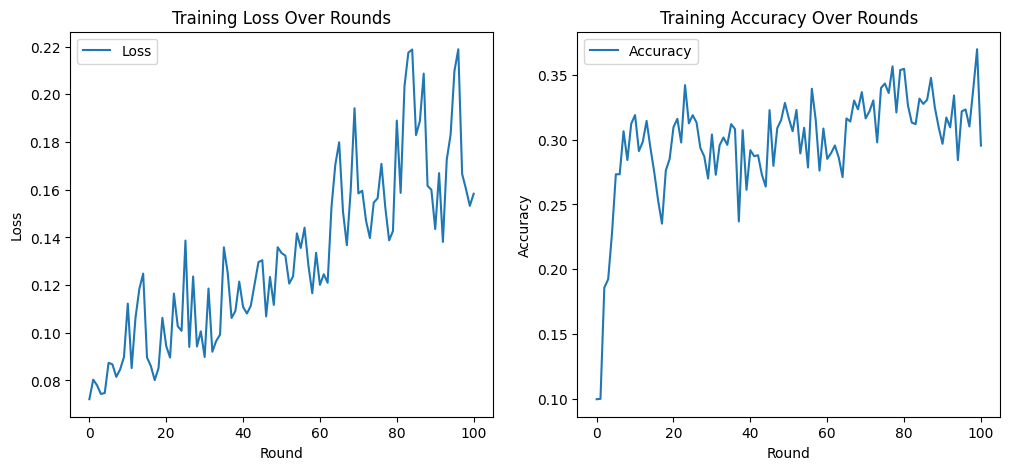

In [19]:
# # Load the loss_history and accuracy_history from local storage
# with open('history/fedprox_iid_loss_history.pkl', 'rb') as f:
#     loss_history = pickle.load(f)
#     print("loss_history loaded from loss_history.pkl")

# with open('history/fedprox_iid_accuracy_history.pkl', 'rb') as f:
#     accuracy_history = pickle.load(f)
#     print("accuracy_history loaded from accuracy_history.pkl")

# Plot the results
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Training Loss Over Rounds')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Rounds')
plt.legend()

plt.show()